### Import

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import random 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from collections import Counter

from tqdm.notebook import tqdm
tqdm.pandas()
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.util import xml_escape
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.cluster import KMeansClusterer, cosine_distance
#nltk.download('stopwords')
#nltk.download("vader_lexicon")                                  # only on the first run
#nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

from transformers import pipeline, BertTokenizer

import pyLDAvis
pyLDAvis.enable_notebook()
from gensim.models import Word2Vec
from gensim import models, corpora
from gensim.models.phrases import Phrases
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel

from langdetect import detect, DetectorFactory

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Phase 1: Products link's web-scraping

## 1.0 Getting the links:

In [ ]:
# optional: gettin a random user_agent
 
with open('user-agents.txt') as agent:             #https://gist.github.com/pzb/b4b6f57144aea7827ae4
    agents = [line.rstrip() for line in agent]
    
user_agent = random.choice(agents)

In [2]:
# or setting it manually

user_agent = 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.130 Safari/537.36'

In [41]:
header = {'User-Agent': user_agent} 

link = 'https://www.amazon.com/s?k=apple&i=electronics&rh=n%3A493964%2Cp_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&s=review-rank&dc&crid=31M7QKA3644X5&qid=1687185560&rnid=1248877011&sprefix=apple%2Caps%2C285&ref=sr_nr_p_72_4&ds=v1%3AcJjOxB6PAGFZt5bfTPgzbeCuGBqn0HoJuU%2F6OHN2KVw'

In [58]:
# This definition get's the html as a soup file given an url (foundamental)

def get_soup(url):
    r = requests.get('http://localhost:8048/render.html', params={'url':url, 'wait':random.randint(2,4)}, headers = header) 
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

# we're using Splash on the 8048 port, it's a tool that runs on Docker and is used to render HTML pages

In [59]:
# This definition get's the number of pages found by the research (covering all three cases)

def nPages(url):
    soup = get_soup(url)
    
    lotOfPages = soup.find("span",{'class' : 's-pagination-item s-pagination-disabled'})      #>4 pages
    if lotOfPages is not None:
        n = (int(lotOfPages.text))
        
    elif lotOfPages is None:
        fewPages = soup.find_all("a", {'class' : 's-pagination-item s-pagination-button'})   #1<pages<4
        if len(fewPages) != 0 :
            n = (int(len(fewPages))+1)
            
        else:
            n = 1                                                                            #1 page

    return int(n)

In [60]:
# Given the url and the number of pages, this definition get's every page's link

def get_pages_links(url, limit):
    pageLinks = []
    for num in range(1,limit+1):
        pageLinks.append(f'{url.split("&qid=")[0]}&page={num}&qid={url.split("&qid=")[1].split("&ref=")[0]}&ref=sr_pg_{num}')
    return pageLinks

In [61]:
# This definition extract the link of every product listed on a single page

def get_links(url):
    soup = get_soup(url)
    productLinks = []
    
    links = soup.find_all("a", attrs = {'class' : 'a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal'})
    for htmlLink in range(0, len(links)):
        link= f'https://www.amazon.com{links[htmlLink].get("href")}'
        productLinks.append(link)
    if len(productLinks) > 24:
        productLinks = productLinks[:24]
    return productLinks

In [62]:
# We now combine the previous definitions, this process obtain, given a research url, the link to every product listed in every page

def get_products_links(url):
    pagelinks = get_pages_links(url, nPages(url))
    print(f'{len(pagelinks)} page links found')
    product_links = []

    pagecount = 1
    for pagelink in pagelinks:
        new_links = get_links(pagelink)
        product_links = product_links + new_links
        print(f'Processin page {pagecount} - extracted {len(new_links)} links - given a total of {len(product_links)} links')
        pagecount +=1
        
    return product_links

In [63]:
links = get_products_links(link)

9 page links found
Processin page 1 - extracted 24 links - given a total of 24 links
Processin page 2 - extracted 24 links - given a total of 48 links
Processin page 3 - extracted 24 links - given a total of 72 links
Processin page 4 - extracted 24 links - given a total of 96 links
Processin page 5 - extracted 24 links - given a total of 120 links
Processin page 6 - extracted 24 links - given a total of 144 links
Processin page 7 - extracted 24 links - given a total of 168 links
Processin page 8 - extracted 24 links - given a total of 192 links
Processin page 9 - extracted 10 links - given a total of 202 links


In [67]:
print(links[random.randint(0,201)])

https://www.amazon.com/Apple-Lightning-Headphone-Jack-Adapter/dp/B01LXJFMGF/ref=sr_1_43?crid=31M7QKA3644X5&keywords=apple&qid=1687186310&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-43


## 1.1 Reviews' web-scraping:

In [68]:
# Convert a product link to his first "all reviews" page link

def prod_to_allrew(url):
    return (url.split('/dp/')[0]+'/product-reviews/'+url.split('/dp/')[1].split('/ref=')[0])

In [69]:
# This definition get's a list with all the reviews from a single page (every review as a dict)

def get_reviews(url):
    content = []
    soup = get_soup(url)
    reviews = soup.find_all('div', {'data-hook' : 'review'})
    for item in reviews:
        review = {
        'product' : soup.title.text.replace('Amazon.com: Customer reviews: ','').strip() ,
        'title' : item.find('a', {'data-hook':'review-title'}).text.strip() ,
        'rating' : float(item.find('i', {'data-hook':'review-star-rating'}).text.replace(' out of 5 stars','').replace(',','.').strip()) ,
        'body' : item.find('span',{'data-hook':'review-body'}).text.replace('Read more','').strip()
        }
        content.append(review)
    return content

In [98]:
# Given the previous definitions, this process extracts every review for each product

def extract_reviews(products_links, already_done, allreviews):
    
    if len(allreviews)==0:                            # at the first start, with no default input, it creates
        print('No backup input, starting from zero')  # the allreview dict and the already_done list, then
        for product in products_links:   
            # it starts from the backups if wanted
            allreviews[product]=[]
    else: 
        print('Starting from backups')
        for product in products_links:                
            if product not in allreviews:
                allreviews[product]=[]
    
    
    for product in allreviews:    
        if product not in already_done:       # it starts from the last backup
        
            print(f'Processing product: {product} , already processed {len(already_done)} products')
            
            for number in range(1,501):                                       # amazon keeps max 500 pages
                npagelink = f'{prod_to_allrew(product)}?pageNumber={number}'
                print(f'Processing page: {number} : {npagelink}')
                
                connection = False                                            # this while loop makes sure 
                while not connection:                                         # that the htlm is rendered
                    print('connecting...')                                        
                    soup = get_soup(npagelink)
                    try:
                        status = soup.find('h2', {'class' : 'inline-title'})
                        if status is not None:
                            print('connection established')
                            connection = True
                    except Exception as e:                                    # otherwise it waits 5 sec and retry
                        time.sleep(5)
                
                NotAmerican = soup.find('h3', {'data-hook' : 'dp-global-reviews-header'})   # looks fot the "other countries" label
                Otherpage = soup.find('li', {'class' : 'a-disabled a-last'})                # looks for a disabled "next page" button
                
                if NotAmerican is None and Otherpage is None:
                    for tries in range(1,5):                                   # it might happen that, if the page is not fully
                        print(f'Looking for reviews try {tries}...')           # loaded, it wont find any reviews, therefore
                        newreviews = get_reviews(npagelink)                    # skip the product, we make it tries multiple times
                        time.sleep(2)                                          # before confirming that the page is empty and moving on
                    
                        if len(newreviews) > 0:
                            print(f'Found {len(newreviews)} reviews')
                            allreviews[product] = allreviews[product] + newreviews
                            foundreviews = True
                                                                              
                            break
                        else:
                            print('This page looks empty, trying again...')
                            foundreviews = False
                            time.sleep(2)
                            
                    if not foundreviews:                                       # after 5 rendering with no reviews
                        print('> No reviews')                                  # it moves to the next products                                             
                        already_done.append(product) 
                        
                        break
                
                else:                                                          # if it finds reviews from other countries
                    print('> No more American reviews or no more pages')       # or a blank "next page" it moves on
                    already_done.append(product) 

                    break
     
    return allreviews, already_done

In [153]:
#reviews, already_done = {}, [] only on first run!

for i in range(0, 202, 2):
    reviews, already_done = extract_reviews(links[i :i+2], already_done, reviews) 
    print('# DONE with two products')
    %store reviews already_done

Starting from backups
Processing product: https://www.amazon.com/Apple-Thunderbolt-cable-2-0-m/dp/B00YHUBV6Q/ref=sr_1_85?crid=31M7QKA3644X5&keywords=apple&qid=1687186321&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-85 , already processed 84 products
Processing page: 1 : https://www.amazon.com/Apple-Thunderbolt-cable-2-0-m/product-reviews/B00YHUBV6Q?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-Thunderbolt-cable-2-0-m/product-reviews/B00YHUBV6Q?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 3 : https://www.amazon.com/Apple-Thunderbolt-cable-2-0-m/product-reviews/B00YHUBV6Q?pageNumber=3
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 4 : https://www.amazon.com/Apple-Thunderbolt-ca

connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 6 : https://www.amazon.com/Apple-Smart-Keyboard-10-5-inch-iPad/product-reviews/B072MHN91T?pageNumber=6
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 7 : https://www.amazon.com/Apple-Smart-Keyboard-10-5-inch-iPad/product-reviews/B072MHN91T?pageNumber=7
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 8 : https://www.amazon.com/Apple-Smart-Keyboard-10-5-inch-iPad/product-reviews/B072MHN91T?pageNumber=8
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https://www.amazon.com/Apple-Smart-Keyboard-10-5-inch-iPad/product-reviews/B072MHN91T?pageNumber=9
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 10 : https://www.amazon.com/Apple-Smart-Keyboard-10-5-inch-iPad/product-reviews/B072MHN91T?pageNumber=

connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
Found 10 reviews
Processing page: 13 : https://www.amazon.com/Apple-Keyboard-Numeric-Computers-Silicon/product-reviews/B09V3JXSS9?pageNumber=13
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 14 : https://www.amazon.com/Apple-Keyboard-Numeric-Computers-Silicon/product-reviews/B09V3JXSS9?pageNumber=14
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon.com/Apple-MagSafe-Adapter-17-

Found 10 reviews
Processing page: 6 : https://www.amazon.com/Apple-Cellular-Midnight-Aluminum-Always/product-reviews/B0BDJ1MYMW?pageNumber=6
connecting...
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 7 : https://www.amazon.com/Apple-Cellular-Midnight-Aluminum-Always/product-reviews/B0BDJ1MYMW?pageNumber=7
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 8 : https://www.amazon.com/Apple-Cellular-Midnight-Aluminum-Always/product-reviews/B0BDJ1MYMW?pageNumber=8
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https://www.amazon.com/Apple-Cellular-Midnight-Aluminum-Always/product-reviews/B0BDJ1MYMW?pageNumber=9
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 10 : https://www.amazon.com/Apple-Cellular-Midnight-Aluminum-Always/product-reviews/B0BDJ1MYMW?pageNumber=10
connecting...
c

connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-Smart-Folio-iPad-11-inch/product-reviews/B0932M7VJ2?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 3 : https://www.amazon.com/Apple-Smart-Folio-iPad-11-inch/product-reviews/B0932M7VJ2?pageNumber=3
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
Found 10 reviews
Processing page: 4 : https://www.amazon.com/Apple-Smart-Folio-iPad-11-inch/product-reviews/B0932M7VJ2?pageNumber=4
connecting...
connection established
> No more American reviews or no more pages
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-USB-C-VGA-Multiport-Adapter/dp/B00VU2NHVG/ref=sr_1_97?crid=31M7QKA3644X5&keywords=apple&qid=1687186326&refinements=p_n_con

Found 10 reviews
Processing page: 8 : https://www.amazon.com/2020-Apple-Mini-512GB-Storage/product-reviews/B08N5P7TLW?pageNumber=8
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https://www.amazon.com/2020-Apple-Mini-512GB-Storage/product-reviews/B08N5P7TLW?pageNumber=9
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 10 : https://www.amazon.com/2020-Apple-Mini-512GB-Storage/product-reviews/B08N5P7TLW?pageNumber=10
connecting...
connection established
> No more American reviews or no more pages
Processing product: https://www.amazon.com/Apple-MagSafe-Power-Adapter-MacBook/dp/B00488YV4Q/ref=sr_1_100?crid=31M7QKA3644X5&keywords=apple&qid=1687186326&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-100 , already processed 99 products
Processing page: 1 : https://www.amazon.com/Apple-MagSafe-Pow

connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https://www.amazon.com/Apple-iPad-mini-Silicone-Case/product-reviews/B01576NAAI?pageNumber=9
connecting...
connection established
> No more American reviews or no more pages
Processing product: https://www.amazon.com/Apple-Pencil-Generation-Adapter-Tablet/dp/B0BJLFWXB3/ref=sr_1_104?crid=31M7QKA3644X5&keywords=apple&qid=1687186326&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-104 , already processed 103 products
Processing page: 1 : https://www.amazon.com/Apple-Pencil-Generation-Adapter-Tablet/product-reviews/B0BJLFWXB3?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-Pencil-Generation-Adapter-Tablet/product-reviews/B0BJLFWXB3?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
Found 

Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon.com/Apple-MHXH3AM-A-MagSafe-Charger/dp/B08L5NP6NG/ref=sr_1_112?crid=31M7QKA3644X5&keywords=apple&qid=1687186326&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-112 , already processed 111 products
Processing page: 1 : https://www.amazon.com/Apple-MHXH3AM-A-MagSafe-Charger/product-reviews/B08L5NP6NG?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-MHXH3AM-A-MagSafe-Charger/product-reviews/B08L5NP6NG?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 3 : https://www.amazon.com/Apple-MHXH3AM-A-MagSafe-Charger/product-reviews/B08L5NP6NG?pageNumber=3
connectin

Found 10 reviews
Processing page: 5 : https://www.amazon.com/Apple-Generation-Lightning-Resistant-Headphones/product-reviews/B0BDHB9Y8H?pageNumber=5
connecting...
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 6 : https://www.amazon.com/Apple-Generation-Lightning-Resistant-Headphones/product-reviews/B0BDHB9Y8H?pageNumber=6
connecting...
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 7 : https://www.amazon.com/Apple-Generation-Lightning-Resistant-Headphones/product-reviews/B0BDHB9Y8H?pageNumber=7
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
Found 10 reviews
Processing page: 8 : https://www.amazon.com/Apple-Generation-Lightning-Resistant-Headphones/product-reviews/B0BDHB9Y8H?pageNumber=8
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https:

connection established
> No more American reviews or no more pages
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-Smart-Cover-iPad-10-5-inch/dp/B07PP41TNJ/ref=sr_1_121?crid=31M7QKA3644X5&keywords=apple&qid=1687186333&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-121 , already processed 120 products
Processing page: 1 : https://www.amazon.com/Apple-Smart-Cover-iPad-10-5-inch/product-reviews/B07PP41TNJ?pageNumber=1
connecting...
connection established
> No more American reviews or no more pages
Processing product: https://www.amazon.com/Apple-Smart-Folio-iPad-12-9-inch/dp/B07K2K1FCL/ref=sr_1_122?crid=31M7QKA3644X5&keywords=apple&qid=1687186333&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-122 , already 

connection established
Looking for reviews try 1...
Found 3 reviews
Processing page: 2 : https://www.amazon.com/Beats-Fit-Pro-Cancelling-AppleCare/product-reviews/B0BH7KDJDX?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Beats-Fit-Pro-Cancelling-AppleCare/dp/B0BH7GND9D/ref=sr_1_129?crid=31M7QKA3644X5&keywords=apple&qid=1687186333&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-129 , already processed 128 products
Processing page: 1 : https://www.amazon.com/Beats-Fit-Pro-Ca

connection established
> No more American reviews or no more pages
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-AirTag-Leather-Loop-Product/dp/B0932P4DG3/ref=sr_1_135?crid=31M7QKA3644X5&keywords=apple&qid=1687186333&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-135 , already processed 134 products
Processing page: 1 : https://www.amazon.com/Apple-AirTag-Leather-Loop-Product/product-reviews/B0932P4DG3?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-AirTag-Leather-Loop-Product/product-reviews/B0932P4DG3?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 3 : https://www.amazon.com/Apple-AirTag-Leather-Loop-Product/product-reviews/B0932P4

connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 3 : https://www.amazon.com/Apple-Smart-Cover-iPad-Mini/product-reviews/B07PTMPCLN?pageNumber=3
connecting...
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 4 : https://www.amazon.com/Apple-Smart-Cover-iPad-Mini/product-reviews/B07PTMPCLN?pageNumber=4
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 5 : https://www.amazon.com/Apple-Smart-Cover-iPad-Mini/product-reviews/B07PTMPCLN?pageNumber=5
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
Found 10 reviews
Processing page: 6 : https://www.amazon.com/Apple-Smart-Cover-iPad-Mini/product-reviews/B07PTMPCLN?pageNumber=6
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 7 : https://www.amazon.com/Apple-Smart-Cover-iPad-Mi

connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 7 : https://www.amazon.com/Apple-Smart-Screen-Cover-MLJK2ZM/product-reviews/B016MUCKD6?pageNumber=7
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 8 : https://www.amazon.com/Apple-Smart-Screen-Cover-MLJK2ZM/product-reviews/B016MUCKD6?pageNumber=8
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 9 : https://www.amazon.com/Apple-Smart-Screen-Cover-MLJK2ZM/product-reviews/B016MUCKD6?pageNumber=9
connecting...
connection established
> No more American reviews or no more pages
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-Leather-Sleeve-MacBook-13-inch/dp/B07FKQNVWK/ref=sr_1_145?crid=31M7QKA3644X5&keywords=apple&qid=1687186340&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A124888201

connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-MX4F2ZM-A-AirTag-Loop/dp/B0932R62GX/ref=sr_1_153?crid=31M7QKA3644X5&keywords=apple&qid=1687186340&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-153 , already processed 152 products
Processing page: 1 : https://www.amazon.com/Apple-MX4F2ZM-A-AirTag-Loop/product-reviews/B0932R62GX?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 10 reviews
Processing page: 2 : https://www.amazon.com/Apple-MX4F2ZM-A-AirTag-Loop/p

This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon.com/Apple-2023-MacBook-Laptop-chip/dp/B0C75NSLJY/ref=sr_1_160?crid=31M7QKA3644X5&keywords=apple&qid=1687186340&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-160 , already processed 159 products
Processing page: 1 : https://www.amazon.com/Apple-2023-MacBook-Laptop-chip/product-reviews/B0C75NSLJY?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
Found 3 reviews
Processing page: 2 : https://www.amazon.com/Apple-2023-MacBook-Laptop-chip/product-reviews/B0C75NSLJY?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...


connecting...
connection established
Looking for reviews try 1...
Found 1 reviews
Processing page: 2 : https://www.amazon.com/Apple-Mac-Mini-Early-2023/product-reviews/B0C15136F9?pageNumber=2
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-Watch-Starlight-Aluminium-Sport/dp/B0BHGZVDZB/ref=sr_1_169?crid=31M7QKA3644X5&keywords=apple&qid=1687186346&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-169 , already processed 168 products
Processing page: 1 : https://www.amazon.com/Apple-Wa

connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon.com/Apple-Mac-Mini-Early-2023/dp/B0BZNWKKYL/ref=sr_1_178?crid=31M7QKA3644X5&keywords=apple&qid=1687186346&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-178 , already processed 177 products
Processing page: 1 : https://www.amazon.com/Apple-Mac-Mini-Early-2023/product-reviews/B0BZNWKKYL?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews

connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon.com/Apple-Watch-Cellular-Starlight-Aluminium/dp/B0BHGGSMQC/ref=sr_1_188?crid=31M7QKA3644X5&keywords=apple&qid=1687186346&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-188 , already processed 187 products
Processing page: 1 : https://www.amazon.com/Apple-Watch-Cellular-Starlight-Aluminium/product-reviews/B0BHGGSMQC?pageNumber=1
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, tryin

This page looks empty, trying again...
> No reviews
# DONE with two products
Stored 'reviews' (dict)
Stored 'already_done' (list)
Starting from backups
Processing product: https://www.amazon.com/Apple-Microsoft-12-Month-Subscription-Download/dp/B09LQ1C712/ref=sr_1_197?crid=31M7QKA3644X5&keywords=apple&qid=1687186354&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-197 , already processed 196 products
Processing page: 1 : https://www.amazon.com/Apple-Microsoft-12-Month-Subscription-Download/product-reviews/B09LQ1C712?pageNumber=1
connecting...
connecting...
connection established
Looking for reviews try 1...
This page looks empty, trying again...
Looking for reviews try 2...
This page looks empty, trying again...
Looking for reviews try 3...
This page looks empty, trying again...
Looking for reviews try 4...
This page looks empty, trying again...
> No reviews
Processing product: https://www.amazon

In [156]:
# This definition removes the products with no reviews and the 'Renewed' ones (optional)

def dict_cleaner(allreviews):
    clearreviews = {}
    for product in allreviews: 
         if len(allreviews[product]) > 0 and 'Renewed' not in allreviews[product][0]['product']:
            clearreviews[product] = allreviews[product]
    return clearreviews

In [165]:
reviews = dict_cleaner(reviews)
num = 0
for product in reviews:
    print(f'Extracted: {len(reviews[product])} reviews from {product}')
    num+=len(reviews[product])
print(num)

Extracted: 90 reviews from https://www.amazon.com/Apple-Power-Adapter-Extension-MacBook/dp/B00VU31O7Y/ref=sr_1_1?crid=31M7QKA3644X5&keywords=apple&qid=1687186302&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-1
Extracted: 40 reviews from https://www.amazon.com/2021-Apple-10-2-inch-iPad-Wi-Fi/dp/B09QHXJ3YP/ref=sr_1_2?crid=31M7QKA3644X5&keywords=apple&qid=1687186302&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-2
Extracted: 8 reviews from https://www.amazon.com/Apple-Watch-GPS-44mm-AppleCare/dp/B081KL5FTZ/ref=sr_1_3?crid=31M7QKA3644X5&keywords=apple&qid=1687186302&refinements=p_n_condition-type%3A2224371011%2Cp_89%3AApple%2Cp_72%3A1248882011&rnid=1248877011&s=electronics&sprefix=apple%2Caps%2C285&sr=1-3
Extracted: 90 reviews from https://www.amazon.com/Apple-Watch-Midnight-Aluminum-Always/dp/B0BDJBG74R/r

 > After applying the extract_reviews definition to the links we end up with 100 products and a total of 63450 reviews. 

## 1.2 Saving the dataset:

In [ ]:
# Extracting the dict as a file .json 

with open('/Users/dvettore/Desktop/reviewsdf.json', 'w') as f:
    json.dump(reviewsdf, f)

In [189]:
# We also convert the dictionary in a database in order to have the structured data

data = []
for i in reviews:
    link = i
    for l in reviews[i]:
        product_name = l['product']
        title = l['title']
        rating = l['rating']
        text = l['body']
        data.append([link, product_name, title, rating, text])
    time.sleep(1)

df2 = pd.DataFrame(data, columns=['Link', 'Product_name', 'Title', 'Rating', 'Text'])

In [272]:
df.sample(5)

,Link,Product_name,Title,Rating,Text,product
14663,https://www.amazon.com/Apple-MWP22AM-A-AirPods...,Apple AirPods Pro,Solid Apple product . Price is a bit high.,4.0,"They fit and feel nice, look sleek, just wish ...",Pods
9962,https://www.amazon.com/New-Apple-Watch-GPS-40m...,"Apple Watch Series 6 (GPS, 40mm) - Space Gray ...",Quality,5.0,Excellent watch keeps track of my activities,Watch
27326,https://www.amazon.com/Apple-Generation-Cancel...,Apple AirPods Pro (2nd Generation) Wireless Ea...,Perfect!,5.0,I read some bad reviews on these but I love th...,Pods
15070,https://www.amazon.com/Apple-MWP22AM-A-AirPods...,Apple AirPods Pro,Best purchase i have made this year!,5.0,these are the easiest to operate. i love them...,Pods
24722,https://www.amazon.com/Apple-MacBook-16-Inch-S...,"Apple 2019 MacBook Pro (16-inch, 16GB RAM, 512...",great laptop,5.0,"Very nice, great graphics and very fast",MacBook


In [269]:
df2.sample(5)

,Link,Product_name,Title,Rating,Text,product
9605,https://www.amazon.com/Apple-Magic-Keyboard-Co...,"Apple Magic Keyboard with Touch ID: Wireless, ...",Apple is the best!,5.0,I just love Apple! I think you pay more but I...,Keyboard
4830,https://www.amazon.com/Apple-USB-C-Digital-Mul...,Apple USB-C Digital AV Multiport Adapter,M2 MacBook Air to Dell Ultrasharp via HDMI Buggy,1.0,Received scratched and clearly used. White bod...,Cables
8162,https://www.amazon.com/Apple-Smart-Keyboard-iP...,Apple Smart Keyboard: iPad Keyboard and case f...,Typical Apple product,5.0,Easy to use,Keyboard
3530,https://www.amazon.com/Apple-USB-C-Power-Adapt...,Apple 30W USB-C Power Adapter,Extremely fast charging,5.0,It is A LOT faster charging compared to the on...,Cables
5389,https://www.amazon.com/Apple-Magic-Keyboard-En...,"Apple Magic Keyboard: Wireless, Bluetooth, Rec...",Excellent keybosrd,5.0,This is a terrific keyboard. Connects to my Ma...,Keyboard


In [ ]:
# Let's also add a new column with a product label extracted from the product_name

products = {'Cables' : ['USB-C', 'Lightning', 'Thunderbolt', 'MagSafe', 'Adapter', 'Wireless','12W','Cable'],
            'Pods' : ['EarPods' , 'AirPods'], 'Mac' : ['MacBook', 'iMac', 'Mac Mini'], 'Keyboard' :['Keyboard'],
            'Case' : ['Cover', 'Folio','Follo', 'iPhone'], 'Watch' : ['Watch'] , 'Trackpad' : ['Trackpad'], 
            'Mouse' : ['Mouse'],'Pencil' : ['Pencil'], 'Beats' : ['Beats'], 'iPad' : ['iPad'], 
            'AirTag':[ 'AirTag'], 'Drive':['SuperDrive'], 'TV':['TV'], }

def prodconv(text):
    for prod in products:
        for prd in products[prod]:
            if prd in text[:25]:
                return prod
            
df2['product'] = df2['Product_name'].progress_apply(lambda x: prodconv(x))

In [276]:
df.shape

(51613, 6)

In [277]:
df2.shape

(11837, 6)

In [278]:
df_concat = pd.concat([df, df2[~df2[['Title', 'Text']].isin(df[['Title', 'Text']]).all(axis=1)]])
df_concat = df_concat.reset_index(drop=True)

In [473]:
df_concat[df_concat['Text']==''] = 'DELETE'
df_concat[df_concat['Text'].isnull()] = 'DELETE'
df_concat[df_concat['Text']=='DELETE']
df_concat = df_concat.drop(missing_values.index)
df_concat = df_concat.reset_index(drop=True)

In [474]:
reviewsDf = df_concat.copy()

In [478]:
reviewsDf.to_excel('/Users/dvettore/Desktop/reviewsDf.xlsx', index=False)

In [505]:
reviewsDf['Rating'] = reviewsDf['Rating'].astype(np.int64)

In [244]:
reviewsDf['product'].value_counts()

Cables      19297
Pods        17814
Keyboard     5803
Pencil       5361
iPad         4265
Watch        3885
Mac          3358
Mouse        1446
Case          876
AirTag        340
Trackpad      298
TV            270
Beats          93
Drive          90
Name: product, dtype: int64

In [482]:
reviewsDf['Rating'].value_counts()

5.0    43128
1.0     7227
4.0     6933
3.0     3722
2.0     2255
Name: Rating, dtype: int64

In [22]:
reviewsDf.sample(5)

,Link,Product_name,Title,Rating,Text,product
39267,https://www.amazon.com/Apple-Pencil-1st-Genera...,Apple Pencil (1st Generation): Pixel-Perfect P...,Very Apple,3,As someone who is not completely bound by the ...,Pencil
19132,https://www.amazon.com/Apple-MHXH3AM-A-MagSafe...,Apple MagSafe Charger - Wireless Charger with ...,Fragility,1,"Don’t waste your money, did not last long , fe...",Cables
5052,https://www.amazon.com/Apple-MacBook-13-inch-2...,"Apple 2020 MacBook Air Laptop M1 Chip, 13&#34;...","Fast, responsive and beautifully crafted",5,Replaced a previous MacBook Air with the new v...,Mac
46907,https://www.amazon.com/Apple-AirPods-Charging-...,Apple AirPods (2nd Generation) Wireless Earbud...,Great use!,5,This was a great purchase,Pods
55680,https://www.amazon.com/Apple-MU8F2AM-A-Pencil-...,Apple Pencil (2nd Generation): Pixel-Perfect P...,Price,4,"Price was good, working fine. Pleased with pur...",Pencil


> il dataframe finale è reviewsDf, contiene 63265 recensioni ottenute da 199 prodotti diversi, non contiene osservazioni con testo nullo 

# Phase 2: Sentiment Analysis

## 2.0 Vader approach:

In [25]:
df_vader = reviewsDf[['Rating','Text']].copy()

In [509]:
df_vader[1111:1116]

,Rating,Text
1111,4,Bring sound right to your ears. One end connec...
1112,5,Came in good shape and works fine to me. I eve...
1113,2,Made a very loud noise over the mic when plugg...
1114,1,"Despite being purchased from the apple store, ..."
1115,5,had for over 5 months now and I love them will...


In [26]:
sent_analyzer = SentimentIntensityAnalyzer()

In [27]:
print(df_vader['Text'].iloc[77])
print(f'Vader: {sent_analyzer.polarity_scores(df["Text"].iloc[77])}')

I have AirPods but prefer to use plug in headphones on my work computer these are perfect
Vader: {'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'compound': 0.7227}


In [28]:
# Basic sentiment analysis with -0.6, -0.2, 0.2, 0.6 as compound's thresholds

df_vader[['neg', 'neu', 'pos', 'compound']] = df_vader["Text"].progress_apply(lambda x: pd.Series(sent_analyzer.polarity_scores(x)))
df_vader['vader_rating']= np.digitize(df_vader['compound'], np.arange(-1, 1.01, 0.4))

  0%|          | 0/63265 [00:00<?, ?it/s]

In [501]:
df_vader[1111:1116]

,Rating,Text,neg,neu,pos,compound,vader_rating
1111,4.0,Bring sound right to your ears. One end connec...,0.000,0.895,0.105,0.3804,4
1112,5.0,Came in good shape and works fine to me. I eve...,0.000,0.680,0.320,0.8126,5
1113,2.0,Made a very loud noise over the mic when plugg...,0.000,1.000,0.000,0.0000,3
1114,1.0,"Despite being purchased from the apple store, ...",0.107,0.893,0.000,-0.9425,1
1115,5.0,had for over 5 months now and I love them will...,0.071,0.645,0.284,0.7650,5


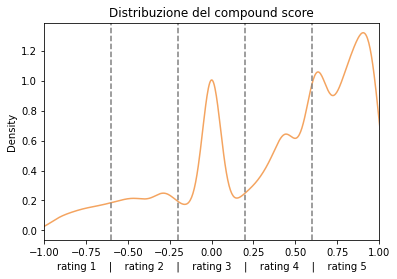

In [35]:
df_vader['compound'].plot(kind='kde', xlim=(-1,1), title = 'Distribuzione del compound score', color = 'sandybrown')
plt.xlabel('rating 1    |    rating 2    |    rating 3    |    rating 4    |    rating 5')
plt.axvline(x=-0.6, color='gray', linestyle='--')
plt.axvline(x=-0.2, color='gray', linestyle='--')
plt.axvline(x=0.2, color='gray', linestyle='--')
plt.axvline(x=0.6, color='gray', linestyle='--')
plt.show()


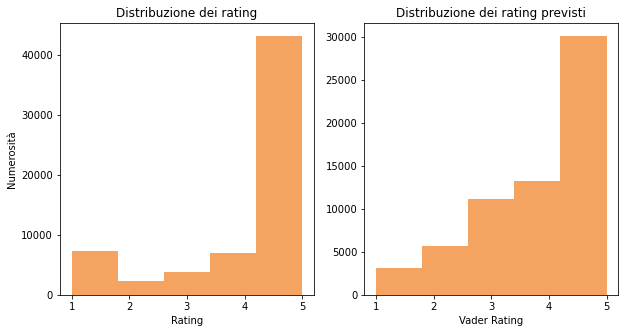

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].hist(df_vader['vader_rating'], bins = 5, color ='sandybrown')
axs[1].set_title('Distribuzione dei rating previsti')
axs[0].set_ylabel('Numerosità')
axs[1].set_xlabel('Vader Rating')
axs[0].hist(df_vader['Rating'], bins = 5, color ='sandybrown')
axs[0].set_title('Distribuzione dei rating')
axs[0].set_xlabel('Rating')
plt.show()

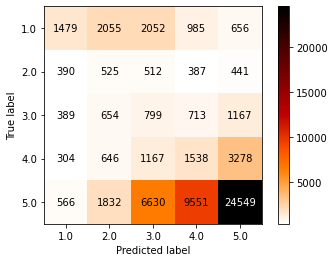

In [45]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(df_vader['Rating'], df_vader['vader_rating'], labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [518]:
print(f"Accuracy: {accuracy_score(df_vader['Rating'], df_vader['vader_rating'])}")

off_by_one = 0
for index, row in df_vader.iterrows():
    if abs(row['Rating'] - row['vader_rating']) <= 1:
        off_by_one += 1

accuracy_off_by_one = off_by_one / len(df_vader)
print(f"""Accuracy off-by-one: {accuracy_off_by_one}
""")

print(classification_report(df_vader['Rating'], df_vader['vader_rating']))

Accuracy: 0.45665059669643565
Accuracy off-by-one: 0.7462261914170553

              precision    recall  f1-score   support

           1       0.47      0.20      0.29      7227
           2       0.09      0.23      0.13      2255
           3       0.07      0.21      0.11      3722
           4       0.12      0.22      0.15      6933
           5       0.82      0.57      0.67     43128

    accuracy                           0.46     63265
   macro avg       0.31      0.29      0.27     63265
weighted avg       0.63      0.46      0.52     63265



In [520]:
# Pre-processed text's sentiment analysis with -0.6, -0.2, 0.2, 0.6 as compound's thresholds

df_vader_preprocess = reviewsDf[['Rating','Text']].copy()
df_vader_preprocess['Text'] = df_vader_preprocess['Text'].str.lower().str.replace(r'[^a-zA-Z]+', ' ', regex=True)
df_vader_preprocess['Text'] = df_vader_preprocess['Text'].progress_apply(lambda x: ' '.join([w for w in x.split() if len(w) >1]))

df_vader_preprocess[['neg', 'neu', 'pos', 'compound']] = df_vader_preprocess["Text"].progress_apply(lambda x: pd.Series(sent_analyzer.polarity_scores(x)))
df_vader_preprocess['vader_rating']= np.digitize(df_vader_preprocess['compound'], np.arange(-1, 1.01, 0.4))

  0%|          | 0/63265 [00:00<?, ?it/s]

  0%|          | 0/63265 [00:00<?, ?it/s]

In [521]:
df_vader_preprocess[1111:1116]

,Rating,Text,neg,neu,pos,compound,vader_rating
1111,4,bring sound right to your ears one end connect...,0.087,0.913,0.000,-0.2912,2
1112,5,came in good shape and works fine to me even c...,0.000,0.680,0.320,0.8126,5
1113,2,made very loud noise over the mic when plugged...,0.000,1.000,0.000,0.0000,3
1114,1,despite being purchased from the apple store t...,0.099,0.901,0.000,-0.9294,1
1115,5,had for over months now and love them will buy...,0.071,0.645,0.284,0.7650,5


In [522]:
print(f"Accuracy: {accuracy_score(df_vader_preprocess['Rating'], df_vader_preprocess['vader_rating'])}")

off_by_one = 0
for index, row in df_vader_preprocess.iterrows():
    if abs(row['Rating'] - row['vader_rating']) <= 1:
        off_by_one += 1

accuracy_off_by_one = off_by_one / len(df_vader_preprocess)
print(f"""Accuracy off-by-one: {accuracy_off_by_one}
""")

print(classification_report(df_vader_preprocess['Rating'], df_vader_preprocess['vader_rating']))

Accuracy: 0.4506441160199162
Accuracy off-by-one: 0.7459732869675176

              precision    recall  f1-score   support

           1       0.48      0.19      0.27      7227
           2       0.09      0.22      0.13      2255
           3       0.07      0.21      0.11      3722
           4       0.11      0.22      0.15      6933
           5       0.81      0.56      0.66     43128

    accuracy                           0.45     63265
   macro avg       0.31      0.28      0.26     63265
weighted avg       0.62      0.45      0.51     63265



In [46]:
# Using a gridsearch in order to try different thresholds' combinations

df_vader_gridsearch = df_vader[['Rating','Text','compound']].copy()

In [47]:
# This definition convert the compound score into a rating given the list of thresholds

def cat_compound(c:float, ths: list) -> int:
    if c <= ths[0]:
        return 1
    elif c <= ths[1]:
        return 2
    elif c <= ths[2]:
        return 3
    elif c <= ths[3]:
        return 4
    else:
        return 5

In [48]:
thresholds = []
for i in range(-1, 3):
    for j in range(-1, 3):
        for k in range(-1, 3):
            for l in range(-1, 3):
                thresholds.append([round(-0.6 + i*0.1 , 2),   # list with all possible thresholds combinations
                              round(-0.2 + j*0.1, 2),         # [-0.6, -0.2, 0.2, 0.6] each +-0.1 and +-0.2
                              round(0.2 + k*0.1, 2),
                              round(0.6 + l*0.1, 2)])
thresholds[:5]

[[-0.7, -0.3, 0.1, 0.5],
 [-0.7, -0.3, 0.1, 0.6],
 [-0.7, -0.3, 0.1, 0.7],
 [-0.7, -0.3, 0.1, 0.8],
 [-0.7, -0.3, 0.2, 0.5]]

In [49]:
results = {}
for ths in thresholds:
    df_vader_gridsearch['vader_rating'] = df_vader_gridsearch['compound'].apply(lambda x: cat_compound(x, ths))
    accuracy = accuracy_score(df_vader_gridsearch['Rating'], df_vader_gridsearch['vader_rating'])
    results[str(ths)] = accuracy

In [50]:
max_key, max_value = max(results.items(), key=lambda x: x[1])
print(f"Best combination: thresholds: {max_key} | accuracy: {max_value}")

Best combination: thresholds: [-0.4, -0.3, 0.1, 0.5] | accuracy: 0.5107879554255907


In [528]:
# Applying the best thresholds combination

df_vader_gridsearch['vader_rating'] = df_vader_gridsearch['compound'].apply(lambda x: cat_compound(x, [float(value) for value in max_key.strip('[]').split(',')]))

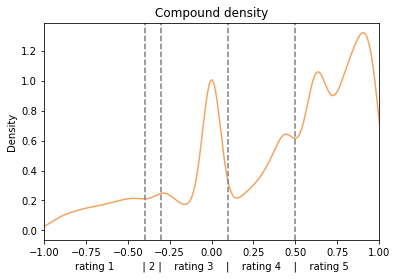

In [529]:
df_vader_gridsearch['compound'].plot(kind='kde', xlim=(-1,1), title = 'Compound density', color = 'sandybrown')
plt.xlabel('rating 1         | 2 |    rating 3    |    rating 4    |    rating 5')
plt.axvline(x=-0.4, color='gray', linestyle='--')
plt.axvline(x=-0.3, color='gray', linestyle='--')
plt.axvline(x=0.1, color='gray', linestyle='--')
plt.axvline(x=0.5, color='gray', linestyle='--')
plt.show()

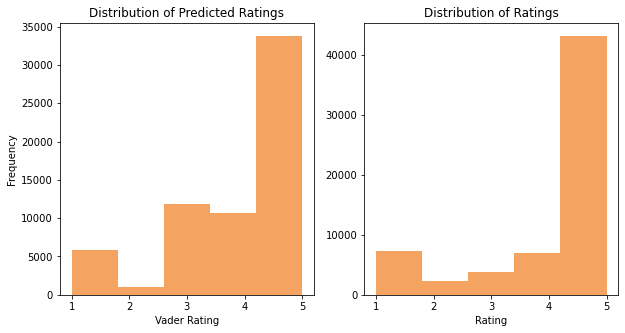

In [530]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(df_vader_gridsearch['vader_rating'], bins = 5, color ='sandybrown')
axs[0].set_title('Distribution of Predicted Ratings')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Vader Rating')
axs[1].hist(df_vader_gridsearch['Rating'], bins = 5, color ='sandybrown')
axs[1].set_title('Distribution of Ratings')
axs[1].set_xlabel('Rating')

plt.show()

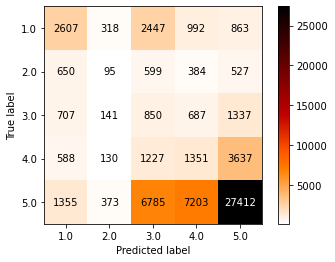

In [531]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(df_vader_gridsearch['Rating'], df_vader_gridsearch['vader_rating'], labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [532]:
print(f"Accuracy: {accuracy_score(df_vader_gridsearch['Rating'], df_vader_gridsearch['vader_rating'])}")

off_by_one = 0
for index, row in df_vader_gridsearch.iterrows():
    if abs(row['Rating'] - row['vader_rating']) <= 1:
        off_by_one += 1

accuracy_off_by_one = off_by_one / len(df_vader_gridsearch)
print(f"""Accuracy off-by-one: {accuracy_off_by_one}
""")

print(classification_report(df_vader_gridsearch['Rating'], df_vader_gridsearch['vader_rating']))

Accuracy: 0.5107879554255907
Accuracy off-by-one: 0.7393819647514424

              precision    recall  f1-score   support

           1       0.44      0.36      0.40      7227
           2       0.09      0.04      0.06      2255
           3       0.07      0.23      0.11      3722
           4       0.13      0.19      0.15      6933
           5       0.81      0.64      0.71     43128

    accuracy                           0.51     63265
   macro avg       0.31      0.29      0.29     63265
weighted avg       0.63      0.51      0.56     63265



## 2.1 ML models approach:

In [248]:
stop = stopwords.words('english')

df_ml = reviewsDf[['Rating','Text']].copy()

# Basic preprocessing needed
df_ml['clear_text'] = df_ml['Text'].str.lower().str.replace(r'[^a-zA-Z]+', ' ', regex=True)
df_ml['clear_text'] = df_ml['clear_text'].progress_apply(lambda x: ' '.join([w for w in x.split() if len(w) >1 and w not in stop]))

  0%|          | 0/63265 [00:00<?, ?it/s]

In [249]:
df_ml['Rating'].value_counts()

5    43128
1     7227
4     6933
3     3722
2     2255
Name: Rating, dtype: int64

In [250]:
(100*43128)/63265

68.170394372876

In [253]:
all_words = [word for text in df_ml['clear_text'] for word in text.split()]
vocab = set(all_words)
c = Counter(all_words)

word_freq = pd.DataFrame.from_dict(c, orient='index').reset_index()
word_freq = word_freq.rename(columns={"index": "word", 0:"freq"})
word_freq.sort_values(by=['freq'], ascending = False)
word_freq.sample(5)

,word,freq
6020,defined,5
6229,dislikes,16
4890,sandisk,10
23279,strikingly,1
798,headaches,32


In [254]:
word_freq.describe()

,freq
count,27220.000000
mean,52.234460
std,394.632068
min,1.000000
25%,1.000000
50%,2.000000
75%,9.000000
max,25529.000000


In [255]:
n_features = word_freq[word_freq['freq'] >= 9].shape[0]  # we keep the tokens that appear at least 9 times
print(f'n° of selected tokens: {n_features}')

n° of selected tokens: 6809


In [256]:
word_freq[word_freq['freq'] == 25529]

,word,freq
44,apple,25529


In [257]:
tfidf_model = TfidfVectorizer(max_features=n_features)
text_counts = tfidf_model.fit_transform(df_ml['clear_text']) 

In [258]:
# Ottenere l'array di importanza dei termini dal modello TF-IDF
term_importance = np.asarray(text_counts.mean(axis=0)).ravel()

# Ottenere gli indici dei termini in ordine di importanza decrescente
top_indices = term_importance.argsort()[::-1][:n_features]

# Ottenere i termini corrispondenti agli indici
feature_names = tfidf_model.get_feature_names_out()
top_terms = feature_names[top_indices]

# Ottenere l'importanza dei termini corrispondenti agli indici
top_importance = term_importance[top_indices]

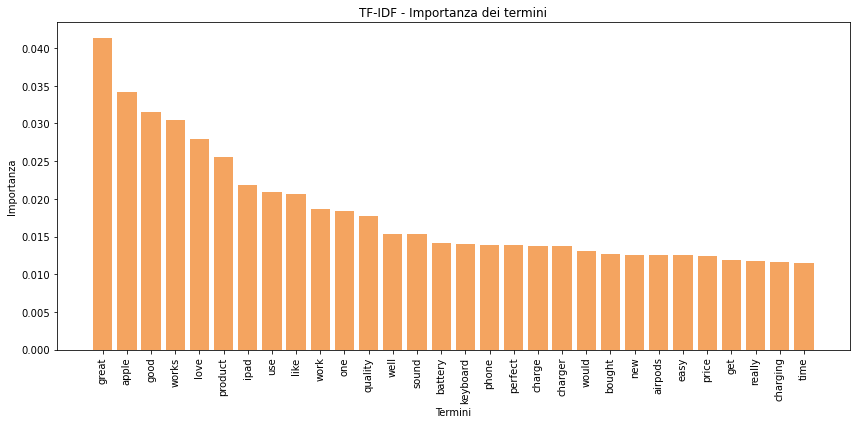

In [259]:
plt.figure(figsize=(12, 6))
plt.bar(range(n_features)[:30], top_importance[:30], align='center', color='sandybrown')
plt.xticks(range(n_features)[:30], top_terms[:30], rotation=90)
plt.xlabel('Termini')
plt.ylabel('Importanza')
plt.title('TF-IDF - Importanza dei termini')
plt.tight_layout()
plt.show()

In [260]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df_ml['Rating'], test_size=0.20, random_state=77)

In [261]:
def offbyone(Ypred, Y):
    off_by_one = 0
    for indx in range(0, len(Y)):
        if abs(Y.iloc[indx] - Ypred[indx]) <= 1:
            off_by_one += 1

    accuracy_off_by_one = off_by_one / len(Y)
    return (f"""Accuracy off-by-one: {accuracy_off_by_one}
""")

In [262]:
# Naive baies UNBALANCED DATA

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

predicted = MNB.predict(X_test)

In [263]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))

Accuracuy Score: 0.7251244764087568
Accuracy off-by-one: 0.8429621433652098

              precision    recall  f1-score   support

           1       0.70      0.43      0.53      1440
           2       1.00      0.00      0.00       420
           3       0.33      0.01      0.01       776
           4       0.32      0.03      0.06      1420
           5       0.73      0.99      0.84      8597

    accuracy                           0.73     12653
   macro avg       0.62      0.29      0.29     12653
weighted avg       0.67      0.73      0.64     12653



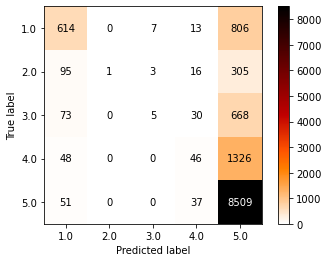

In [264]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [265]:
# Dataset balancing

df_balanced = df_ml[['Rating','Text', 'clear_text']].copy()
print(df_balanced['Rating'].value_counts())                

5    43128
1     7227
4     6933
3     3722
2     2255
Name: Rating, dtype: int64


In [266]:
df2 = df_balanced[df_balanced['Rating'] == 2.0]
df3 = df_balanced[df_balanced['Rating'] == 3.0]

# undersampling
undersamp5 = df_balanced[df_balanced['Rating'] == 5.0].apply(lambda x: x.sample(n=4000, random_state=77)).reset_index(drop=True)
undersamp1 = df_balanced[df_balanced['Rating'] == 1.0].apply(lambda x: x.sample(n=4000, random_state=77)).reset_index(drop=True)
undersamp4 = df_balanced[df_balanced['Rating'] == 4.0].apply(lambda x: x.sample(n=4000, random_state=77)).reset_index(drop=True)

# oversampling
oversamp2 = df_balanced[df_balanced['Rating'] == 2.0].sample(n=1745, random_state=77)
oversamp3 = df_balanced[df_balanced['Rating'] == 3.0].sample(n=278, random_state=77)

df_balanced = pd.concat([undersamp5, undersamp1, undersamp4, oversamp2, oversamp3, df2, df3])
df_balanced = df_balanced.reset_index(drop=True)

In [267]:
df_balanced['Rating'].value_counts()

5    4000
1    4000
4    4000
2    4000
3    4000
Name: Rating, dtype: int64

In [268]:
tfidf_model = TfidfVectorizer(max_features=n_features)
text_counts = tfidf_model.fit_transform(df_balanced['clear_text'])

In [269]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df_balanced['Rating'], test_size=0.20, random_state=77)

In [273]:
# Naive Bayes on balanced data

MNB_classifier = MultinomialNB().fit(X_train, Y_train)

predicted = MNB_classifier.predict(X_test)

In [274]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))               #4000 support cause is 20% of 4000*5

Accuracuy Score: 0.5085
Accuracy off-by-one: 0.82025

              precision    recall  f1-score   support

           1       0.53      0.65      0.58       793
           2       0.48      0.44      0.46       808
           3       0.42      0.35      0.38       814
           4       0.47      0.48      0.48       815
           5       0.63      0.63      0.63       770

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.50      0.51      0.50      4000



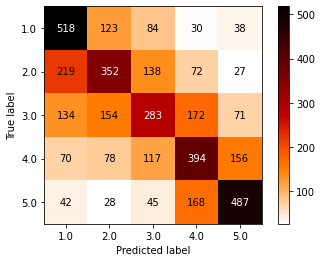

In [275]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [276]:
# MLP on balanced data

MLP_classifier = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, learning_rate='constant', 
                           learning_rate_init=0.0001, activation='relu', solver='adam', random_state=77).fit(X_train, Y_train)

predicted = MLP_classifier.predict(X_test)

In [277]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))   

Accuracuy Score: 0.5565
Accuracy off-by-one: 0.8125

              precision    recall  f1-score   support

           1       0.60      0.52      0.56       793
           2       0.67      0.79      0.73       808
           3       0.48      0.47      0.47       814
           4       0.43      0.41      0.42       815
           5       0.58      0.59      0.59       770

    accuracy                           0.56      4000
   macro avg       0.55      0.56      0.55      4000
weighted avg       0.55      0.56      0.55      4000



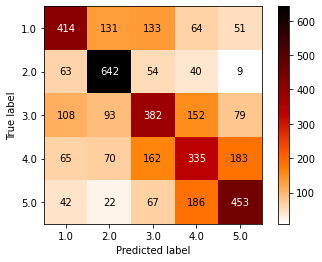

In [278]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [280]:
# SVM linear on balanced data

svm_classifier = SVC(kernel='linear', C=1, random_state=77).fit(X_train, Y_train)

predicted = svm_classifier.predict(X_test)

In [281]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))  

Accuracuy Score: 0.5305
Accuracy off-by-one: 0.8355

              precision    recall  f1-score   support

           1       0.57      0.66      0.62       793
           2       0.52      0.51      0.51       808
           3       0.43      0.38      0.40       814
           4       0.49      0.42      0.45       815
           5       0.62      0.68      0.65       770

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.53      4000
weighted avg       0.52      0.53      0.53      4000



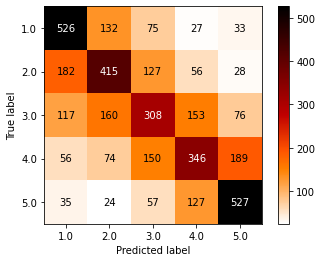

In [282]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [283]:
# SVM with rbf kernel

svm_classifier_rbf = SVC(kernel='rbf', C=1, random_state=77).fit(X_train, Y_train)

predicted = svm_classifier_rbf.predict(X_test)

In [284]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))  

Accuracuy Score: 0.611
Accuracy off-by-one: 0.851

              precision    recall  f1-score   support

           1       0.63      0.72      0.67       793
           2       0.75      0.71      0.73       808
           3       0.51      0.47      0.49       814
           4       0.53      0.51      0.52       815
           5       0.63      0.66      0.65       770

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



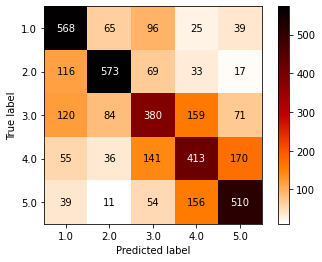

In [285]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [286]:
# SVM with rbf kernel and higher C 

svm_classifier_rbf = SVC(kernel='rbf', C=5, random_state=77).fit(X_train, Y_train)

predicted = svm_classifier_rbf.predict(X_test)

In [287]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))  

Accuracuy Score: 0.6305
Accuracy off-by-one: 0.856

              precision    recall  f1-score   support

           1       0.65      0.70      0.68       793
           2       0.80      0.78      0.79       808
           3       0.53      0.49      0.51       814
           4       0.53      0.51      0.52       815
           5       0.64      0.67      0.65       770

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.63      0.63      0.63      4000



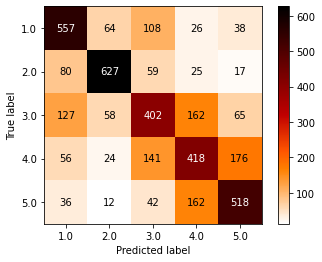

In [288]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [289]:
# RF on balanced data

rf_classifier = RandomForestClassifier(n_estimators=1200, random_state=100).fit(X_train, Y_train)

predicted = rf_classifier.predict(X_test)

In [290]:
print(f"Accuracuy Score: {accuracy_score(predicted, Y_test)}")

print(offbyone(predicted, Y_test))

print(classification_report(Y_test, predicted))  

Accuracuy Score: 0.6315
Accuracy off-by-one: 0.82625

              precision    recall  f1-score   support

           1       0.58      0.77      0.66       793
           2       0.93      0.75      0.83       808
           3       0.58      0.46      0.51       814
           4       0.55      0.52      0.54       815
           5       0.58      0.66      0.62       770

    accuracy                           0.63      4000
   macro avg       0.64      0.63      0.63      4000
weighted avg       0.64      0.63      0.63      4000



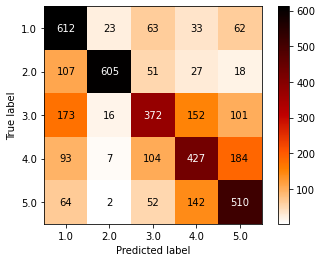

In [291]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(Y_test, predicted, labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

In [231]:
# RF on balanced data NO bootstrap

rf_classifier_nb = RandomForestClassifier(n_estimators=1200, bootstrap = False, random_state=100).fit(X_train, Y_train)
predicted = rf_classifier_nb.predict(X_test)
accuracy_score(predicted, Y_test)

0.624

In [230]:
# Extra-tree classifier

et_classifier = ExtraTreesClassifier(n_estimators=1000, random_state=77).fit(X_train, Y_train)
predicted = et_classifier.predict(X_test)
accuracy_score(predicted, Y_test)

0.63725

In [229]:
# ADAboost

ADA_classifier = AdaBoostClassifier(n_estimators=500, random_state=100).fit(X_train, Y_train)
predicted = ADA_classifier.predict(X_test)
accuracy_score(predicted, Y_test)

0.4285

In [234]:
# GradientBoostingClassifier

GB_classifier = GradientBoostingClassifier(n_estimators=1000, random_state=100).fit(X_train, Y_train)
predicted = GB_classifier.predict(X_test)
accuracy_score(predicted, Y_test)

0.5505

In [239]:
# BaggingClassifier

BG_classifier = BaggingClassifier(n_estimators=1000, random_state=100, n_jobs=-1).fit(X_train, Y_train)
predicted = BG_classifier.predict(X_test)
accuracy_score(predicted, Y_test)

0.58575

## 2.2 fine-tuned model:

In [577]:
# Downloading bert-base-multilingual-uncased-sentiment model from huggingface

model = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [578]:
df_bert = reviewsDf[['Rating','Text']].copy()

In [579]:
# This definition takes the texts and gives back a list of chunks with max 512 tokens each, thats bert model's computational limit

def split_into_chunks(text):
    text_chunks = [text[i:i+510] for i in range(0, len(text), 510)]
    return text_chunks

In [580]:
# Bert's output is a str like "5 stars" and we might also get concat str if multiple chunks, this def normalizes the output

def chunkmerger(sentiment):
    votes = []
    splt = sentiment.split()
    for sent in range(0, len(splt),2):
        votes.append(int(splt[sent]))
    return(round(np.mean(votes), 0))

In [400]:
df_bert['Bert sentiment'] = ""                         
for i, row in df_bert.iterrows():
    text_chunks = split_into_chunks(row['Text'])
    sentiments = []
    for chunk in text_chunks:
        sentiment = model(chunk)[0]
        sentiments.append(sentiment['label'])
    df_bert.at[i, 'Bert sentiment'] = ' '.join(sentiments)

In [401]:
df_bert['Bert rating'] = df_bert['Bert sentiment'].apply(chunkmerger)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [452]:
df_bert.sample(5)

,Rating,Text,Bert sentiment,Bert rating
62477,5.0,I waited a long time to get one,2 stars,2.0
6028,4.0,Not an Apple product but it works well.,4 stars,4.0
50202,5.0,Mouse is as described. The packaging was great.,5 stars,5.0
14938,5.0,Fast delivery as advertised good price and qua...,4 stars,4.0
21771,5.0,I wish I had thought to look on amazon before ...,5 stars,5.0


In [598]:
#185 sono vuoti poichè alcune recensioni non hanno testo, così si sistema

df_bert['Bert rating'].fillna(-1, inplace=True)

missing_values = df_bert[df_bert['Bert rating'] == -1]

df_bert = df_bert.drop(missing_values.index)

In [599]:
df_bert.shape

(63265, 4)

In [600]:
print(f"Accuracy: {accuracy_score(df_bert['Rating'], df_bert['Bert rating'])}")

off_by_one = 0
for index, row in df_bert.iterrows():
    if abs(row['Rating'] - row['Bert rating']) <= 1:
        off_by_one += 1

accuracy_off_by_one = off_by_one / len(df_bert)
print(f"""Accuracy off-by-one: {accuracy_off_by_one}
""")

print(classification_report(df_bert['Rating'], df_bert['Bert rating']))

Accuracy: 0.6235991464474828
Accuracy off-by-one: 0.8870781632814352

              precision    recall  f1-score   support

         1.0       0.65      0.73      0.69      7227
         2.0       0.18      0.44      0.25      2255
         3.0       0.19      0.32      0.24      3722
         4.0       0.22      0.41      0.29      6933
         5.0       0.96      0.68      0.79     43128

    accuracy                           0.62     63265
   macro avg       0.44      0.52      0.45     63265
weighted avg       0.77      0.62      0.67     63265



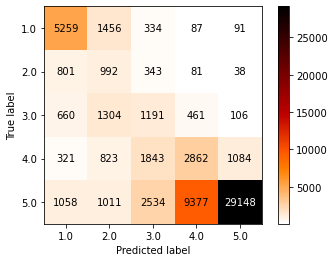

In [601]:
CM = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(df_bert['Rating'], df_bert['Bert rating'], labels=[1.0, 2.0, 3.0,4.0,5.0]),
    display_labels=[1.0, 2.0, 3.0,4.0,5.0])
CM.plot(cmap='gist_heat_r')
plt.show()

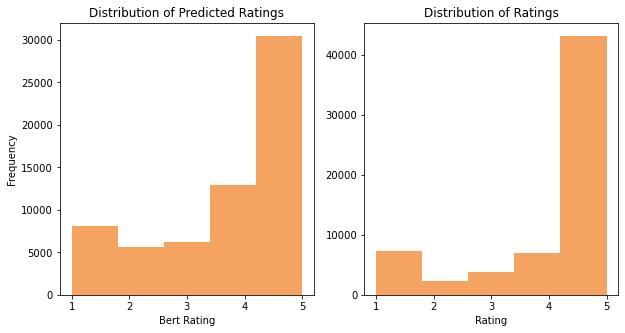

In [602]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(df_bert['Bert rating'], bins = 5, color ='sandybrown')
axs[0].set_title('Distribution of Predicted Ratings')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Bert Rating')
axs[1].hist(df_bert['Rating'], bins = 5, color ='sandybrown')
axs[1].set_title('Distribution of Ratings')
axs[1].set_xlabel('Rating')

plt.show()

# Phase 3: Topic modelling

## 3.2 LDA

In [184]:
df_topic = reviewsDf[['product','Rating','Text']].copy()

In [185]:
# Preprocessing pipeline suggested by gensim and improved:

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary

stop = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

# removing reviews with videos
def finder(text):
    x=0
    if 'Video Player is loading' in text:
        x=1
    return x
df_topic['video?'] = df_topic['Text'].progress_apply(lambda x: finder(x))
df_topic = df_topic.loc[df_topic['video?']==0]
del(df_topic['video?'])

# removing punctation, stopword and whitespaces, lowercasing
def quickprep(text):
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text)
    text = text.lower()
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop])
    return text
df_topic['clear_text'] = df_topic['Text'].progress_apply(lambda x: quickprep(x))

# removing reviews with len < n
def lunghezza(text:str) -> int:
    return len(text)
df_topic['len'] = df_topic['clear_text'].progress_apply(lambda x: lunghezza(x))
df_topic = df_topic.loc[df_topic['len']>= 30]                                           ###

# removing non-eng reviews
def detectlang(text:str) -> str:
    return detect(text)
df_topic['ling'] = df_topic['clear_text'].progress_apply(lambda x: detectlang(x))
df_topic = df_topic.loc[df_topic['ling']=='en']

df_topic = df_topic.reset_index(drop = True)

docs = df_topic['clear_text']

# tokenization and lemmatization
for idx in range(len(docs)): 
    docs[idx] = tokenizer.tokenize(docs[idx])  

docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# bigram!
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

# dictionary creation
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation 
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Gensim tfidf rappresentation (non eseguito)
tfidf_model = models.TfidfModel(corpus)
g_tfidf = tfidf_model[corpus]

  0%|          | 0/63265 [00:00<?, ?it/s]

  0%|          | 0/63168 [00:00<?, ?it/s]

  0%|          | 0/63168 [00:00<?, ?it/s]

  0%|          | 0/47684 [00:00<?, ?it/s]

/var/folders/6w/5m07z1k9289397c2xkpbt6b80000gn/T/ipykernel_39988/1198087577.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])


Number of unique tokens: 4501
Number of documents: 45273


In [186]:
# Lda model

num_topics = 4 
chunksize = 4000
passes = 20
iterations = 1000
eval_every = None  

temp = dictionary[0] 
id2word = dictionary.id2token

g_ldamodel = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state = 77
)

g_lda_display = gensimvis.prepare(g_ldamodel, corpus, dictionary, sort_topics=False, 
                                 mds='mmds', R=30, n_jobs=-1, plot_opts={'plot_width':800, 'plot_height':800})

In [187]:
pyLDAvis.display(g_lda_display)

In [188]:
def get_topic(index):
    topic, rilevance = sorted(g_ldamodel.get_document_topics(corpus[index]), key=lambda x: -x[1])[0] 
    return topic+1 ,rilevance 

In [189]:
df_topic['Index']=df_topic.index
df_topic[['topic', 'relevance']] = df_topic['Index'].progress_apply(get_topic).apply(pd.Series)  
del df_topic['Index']

  0%|          | 0/45273 [00:00<?, ?it/s]

In [190]:
df_topic.sample(5)

,product,Rating,Text,clear_text,len,ling,topic,relevance
8774,Pods,5,I have been looking for months on a great pair of noise canceling ...,"[looking, months, great, pair, noise, canceling, headphones, verge...",252,en,3.0,0.862824
9827,Pods,5,Awesome for conference calls. I do use only one at a time when I’m...,"[awesome, conference, calls, use, one, time, connecting, work, all...",135,en,3.0,0.968145
968,Pods,3,Even though the packaging appeared to be legit the headphones aren...,"[even, though, packaging, appeared, legit, headphones, real, deals...",211,en,3.0,0.512330
4695,Pods,5,My daughter is very happy with these! The sound quality is great.,"[daughter, happy, sound, quality, great]",34,en,3.0,0.889862
22079,Cables,5,"One day at a theme park, my phone was dying from taking so many pi...","[one, day, theme, park, phone, dying, taking, many, pictures, vide...",507,en,4.0,0.428286


In [198]:
# recensione con più rilevanza rispetto a ciascun topic (simil centroide)

max_relevance_idx = df_topic.groupby('topic')['relevance'].idxmax()
result_df = df_topic.loc[max_relevance_idx]
pd.set_option('display.max_colwidth', None)
print(result_df[['Text', 'relevance', 'topic']])
pd.set_option('display.max_colwidth', 70)

In [196]:
# analisi esplorativa cluster

print(df_topic.groupby([ "product", "topic"])["Text"].count())
print(df_topic.groupby("topic")["Text"].count())

product   topic
AirTag    1.0         13
          2.0        238
          3.0          8
          4.0         38
Beats     2.0          4
          3.0         55
          4.0          7
Cables    1.0       1492
          2.0       1065
          3.0        421
          4.0       9954
Case      1.0        421
          2.0         75
          3.0         15
          4.0        144
Drive     1.0         45
          2.0         17
          4.0         24
Keyboard  1.0       3456
          2.0        178
          3.0        129
          4.0        682
Mac       1.0       1755
          2.0        172
          3.0        107
          4.0        546
Mouse     1.0        691
          2.0         50
          3.0         53
          4.0        241
Pencil    1.0       1968
          2.0        237
          3.0        187
          4.0        983
Pods      1.0        173
          2.0        802
          3.0      10158
          4.0       2603
TV        1.0         38
         

In [192]:
topics = {}
for n in range(0,4):
    words = []
    for t in g_ldamodel.get_topic_terms(n, topn=10):
        words.append(f'{dictionary[t[0]]}, {t[0]}')
    topics[f'topic {n+1}'] = words
topics = pd.DataFrame(topics)
topics

,topic 1,topic 2,topic 3,topic 4
0,"ipad, 405","apple, 46","sound, 36","apple, 46"
1,"keyboard, 2818","watch, 1112","airpods, 1","work, 183"
2,"use, 42","phone, 128","ear, 54","product, 276"
3,"apple, 46","use, 42","quality, 29","one, 26"
4,"pro, 28","case, 5","great, 95","cable, 139"
5,"work, 183","iphone, 583","noise, 117","charge, 361"
6,"like, 116","one, 26","good, 114","charger, 1989"
7,"great, 95","time, 40","battery, 363","charging, 50"
8,"screen, 1012","device, 431","life, 331","new, 69"
9,"macbook, 19","get, 148","headphone, 60","amazon, 190"


### LDA on negative reviews

In [215]:
df_negative_topic = reviewsDf[['product','Rating','Text']].copy()
df_negative_topic = df_negative_topic[df_negative_topic['Rating'] < 3]

# removing reviews with videos
def finder(text):
    x=0
    if 'Video Player is loading' in text:
        x=1
    return x
df_negative_topic['video?'] = df_negative_topic['Text'].progress_apply(lambda x: finder(x))
df_negative_topic = df_negative_topic.loc[df_negative_topic['video?']==0]
del(df_negative_topic['video?'])

# removing punctation, stopword and whitespaces, lowercasing
def quickprep(text):
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text)
    text = text.lower()
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop])
    return text
df_negative_topic['clear_text'] = df_negative_topic['Text'].progress_apply(lambda x: quickprep(x))

# removing reviews with len < 30
def lunghezza(text:str) -> int:
    return len(text)
df_negative_topic['len'] = df_negative_topic['clear_text'].progress_apply(lambda x: lunghezza(x))
df_negative_topic = df_negative_topic.loc[df_negative_topic['len']>=50] ###############################

# removing non-eng reviews
def detectlang(text:str) -> str:
    return detect(text)
df_negative_topic['ling'] = df_negative_topic['clear_text'].progress_apply(lambda x: detectlang(x))
df_negative_topic = df_negative_topic.loc[df_negative_topic['ling']=='en']

df_negative_topic = df_negative_topic.reset_index(drop = True)

docs2 = df_negative_topic['clear_text']

# tokenization and lemmatization
for idx in range(len(docs2)): 
    docs2[idx] = tokenizer.tokenize(docs2[idx])  

# removing product names
lista = ['apple','mac', 'lightning', 'thunderbolt', 'magsafe', 'pro','airpods','airpod', 'macbook', 'imac', 'keyboard', 'cover', 'iphone', 'watch', 'trackpad', 'mouse', 'pencil', 'beats', 'ipad', 'superdrive', 'airtag', 'air', 'tag', 'phone']
docs2 = [[token for token in doc if token not in lista] for doc in docs2]

docs2 = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs2]

# bigram!
bigram2 = Phrases(docs2, min_count=20)
for idx in range(len(docs2)):
    for token in bigram2[docs2[idx]]:
        if '_' in token:
            docs2[idx].append(token)

# dictionary creation
dictionary2 = Dictionary(docs2)
dictionary2.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation 
corpus2 = [dictionary2.doc2bow(doc) for doc in docs2]
print('Number of unique tokens: %d' % len(dictionary2))
print('Number of documents: %d' % len(corpus2))

# Gensim tfidf rappresentation (non eseguito)
tfidf_model2 = models.TfidfModel(corpus2)
g_tfidf2 = tfidf_model2[corpus2]

  0%|          | 0/9482 [00:00<?, ?it/s]

  0%|          | 0/9464 [00:00<?, ?it/s]

  0%|          | 0/9464 [00:00<?, ?it/s]

  0%|          | 0/6962 [00:00<?, ?it/s]

/var/folders/6w/5m07z1k9289397c2xkpbt6b80000gn/T/ipykernel_39988/3288086494.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs2[idx] = tokenizer.tokenize(docs2[idx])


Number of unique tokens: 1536
Number of documents: 6799


In [216]:
# lda model

num_topics = 4 #10
chunksize = 2000
passes = 15
iterations = 2000
eval_every = None  

temp = dictionary2[0] 
id2word = dictionary2.id2token

g_ldamodel2 = LdaModel(
    corpus=corpus2,
    id2word=id2word,
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state = 79
)

g_lda_display2 = gensimvis.prepare(g_ldamodel2, corpus2, dictionary2, sort_topics=False, 
                                 mds='mmds', R=30, n_jobs=-1, plot_opts={'plot_width':800, 'plot_height':800})

In [217]:
pyLDAvis.display(g_lda_display2)

In [58]:
def get_topic(index):
    topic, rilevance = sorted(g_ldamodel2.get_document_topics(corpus2[index]), key=lambda x: -x[1])[0] 
    return topic+1 ,rilevance 

In [59]:
df_negative_topic['Index']=df_negative_topic.index
df_negative_topic[['topic', 'relevance']] = df_negative_topic['Index'].progress_apply(get_topic).apply(pd.Series) 
del df_negative_topic['Index']

  0%|          | 0/8650 [00:00<?, ?it/s]

In [67]:
df_negative_topic.sample(5)

,product,Rating,Text,clear_text,len,ling,topic,relevance
4677,Cables,2,I may have gotten a knockoff product? Not sure...,"[may, gotten, knockoff, product, sure, either,...",393,en,4.0,0.795944
4062,Mac,1,Non-Responsive Applications including Safari a...,"[non, responsive, applications, including, saf...",168,en,4.0,0.596921
2754,Cables,1,Slowest charger! Doesn’t come with the wall ou...,"[slowest, charger, come, wall, outlet, part, m...",133,en,4.0,0.711752
8325,Mac,2,"Look, I'm not saying the Apple Mac is bad but ...","[look, saying, apple, mac, bad, amount, money,...",733,en,4.0,0.733208
2251,Cables,1,I used one time and throw it away.IT WAS HOT A...,"[used, one, time, throw, away, hot, hell, phon...",64,en,4.0,0.961971


In [86]:
# recensione con più rilevanza rispetto a ciascun topic (simil centroide)

max_relevance_idx = df_negative_topic.groupby('topic')['relevance'].idxmax()
result_df = df_negative_topic.loc[max_relevance_idx]
pd.set_option('display.max_colwidth', None)
print(result_df['Text'])
pd.set_option('display.max_colwidth', 70)

8012                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [61]:
topics = {}
for n in range(0,4):
    words = []
    for t in g_ldamodel2.get_topic_terms(n, topn=10):
        words.append(f'{dictionary2[t[0]]}, {t[0]}')
    topics[f'topic {n+1}'] = words
topics = pd.DataFrame(topics)
topics

,topic 1,topic 2,topic 3,topic 4
0,"product, 200","ear, 8","month, 54","charge, 1112"
1,"amazon, 110","sound, 28","working, 58","case, 65"
2,"new, 42","quality, 143","one, 17","battery, 264"
3,"one, 17","time, 57","year, 106","phone, 87"
4,"box, 35","headphone, 38","money, 83","one, 17"
5,"return, 21","issue, 185","stopped, 55","would, 292"
6,"item, 186","pair, 19","product, 200","get, 233"
7,"used, 32","noise, 297","worked, 47","adapter, 331"
8,"received, 385","one, 17","stopped_working, 56","usb, 623"
9,"would, 292","airpod, 1469","bought, 63","charging, 478"


In [97]:
problems = {1.0:'amazon/dispatch problems',
            2.0:'sound/earphone problems',
            3.0:'early breakage',
            4.0:'battery/charging problems'}

def texttopic(numtopic):
    return problems[numtopic]

df_negative_topic['problem'] = df_negative_topic['topic'].progress_apply(lambda x: texttopic(x))

  0%|          | 0/8650 [00:00<?, ?it/s]

In [99]:
df_negative_topic['problem'].value_counts()

battery/charging problems    3404
early breakage               2251
amazon/dispatch problems     1954
sound/earphone problems      1041
Name: problem, dtype: int64

In [101]:
df_negative_topic.sample(5)

,product,Rating,Text,clear_text,len,ling,topic,relevance,problem
1488,Watch,1,Does not work if you don't have an iPhone. Can't even use it as a ...,"[work, iphone, even, use, clock, without, iphone, return]",48,en,1.0,0.853754,amazon/dispatch problems
5635,Cables,1,Stopped working after a month of use. I am surprised quite a few r...,"[stopped, working, month, use, surprised, quite, reviews, mentione...",108,en,3.0,0.564639,early breakage
7750,Cables,1,Worked fine but two months later it has died. I have checked my c...,"[worked, fine, two, months, later, died, checked, charge, cords, c...",109,en,3.0,0.975889,early breakage
8309,Watch,1,This watch was LOCKED and could not be used with Verizon. Had to r...,"[watch, locked, could, used, verizon, return, wait, days, refund]",55,en,1.0,0.933594,amazon/dispatch problems
4210,iPad,1,Came with screen crack and completely not able to turn on,"[came, screen, crack, completely, able, turn]",38,en,1.0,0.921442,amazon/dispatch problems


In [105]:
df_negative_topic['product'].value_counts()

Cables      4144
Pods        1636
Keyboard     746
Pencil       470
Mac          404
Watch        392
iPad         305
Mouse        254
Case         200
AirTag        45
Trackpad      23
Beats         11
TV             4
Drive          4
Name: product, dtype: int64

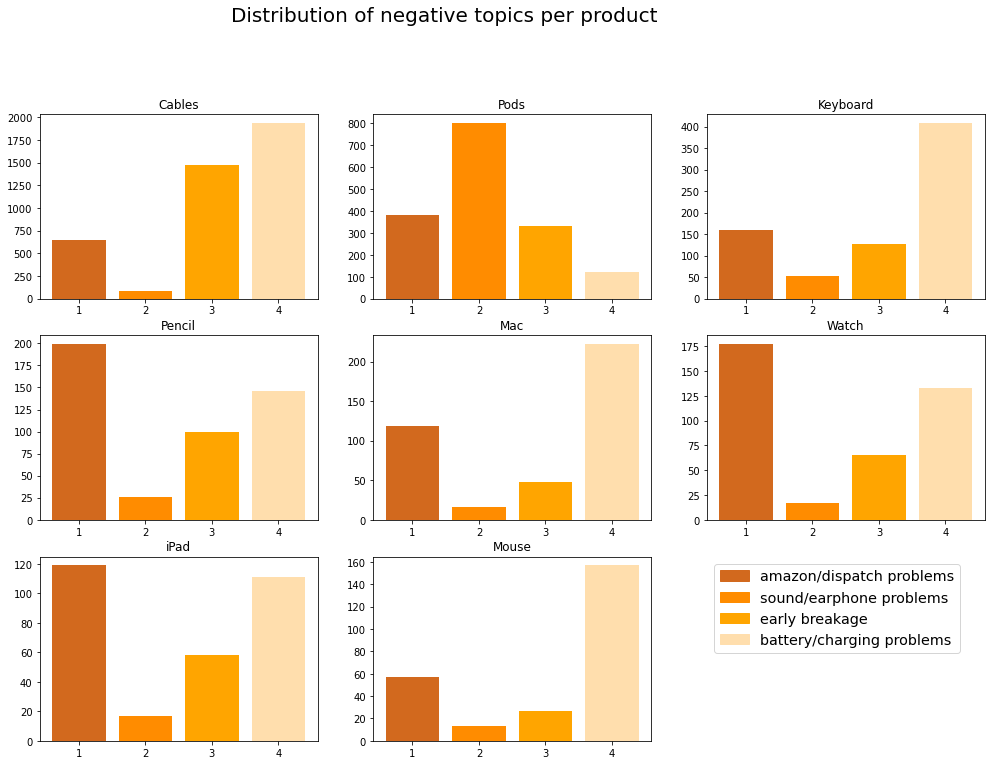

In [143]:
products1 = ['Cables', 'Pods', 'Keyboard']
products2 = ['Pencil', 'Mac', 'Watch'] 
products3 = ['iPad', 'Mouse']

cmap = ListedColormap(['chocolate', 'darkorange','orange','navajowhite'])
topic_names = ['amazon/dispatch problems', 'sound/earphone problems', 'early breakage', 'battery/charging problems']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, products in enumerate([products1, products2, products3]):
    for j, product in enumerate(products):
        for k in range(0,4):
            topic_count = df_negative_topic[(df_negative_topic['product'] == product) & (df_negative_topic['topic'] == float(k+1))]['topic'].count()
            axs[i, j].bar(k+1, topic_count, color=cmap(k))
        axs[i, j].set_title(product)
        axs[i, j].set_xticks([1,2,3,4])

axs[-1, -1].remove()
patches = [plt.Rectangle((0,0),3,2, color=cmap(i)) for i in range(4)]
topic_names = ['amazon/dispatch problems', 'sound/earphone problems', 'early breakage', 'battery/charging problems']
plt.legend(handles=patches, labels=topic_names, bbox_to_anchor=(1.2, 1), loc='upper left', fontsize='x-large')

plt.subplots_adjust(bottom=0.3, right=1)
plt.suptitle('Distribution of negative topics per product', fontsize=20)
plt.show()

In [151]:
def prod_topic_maxrel_finder(prod,topic):
    return df_negative_topic.loc[df_negative_topic.loc[df_negative_topic['product'] == prod].loc[df_negative_topic['topic'] == topic]['relevance'].idxmax()][['Text','relevance']]

In [165]:
pd.set_option('display.max_colwidth', None)
print(prod_topic_maxrel_finder('Keyboard', 4.0))
pd.set_option('display.max_colwidth', 70)

Text         When I use a laptop, I prop it up with a Roost or Nexstand to get it closer to eye level. I was hoping this would be a good compromise, with adjustable viewing angles and tablet slightly raised above the keyboard. Unfortunately I found myself slouching over it with my head down by default (I'm tall, ymmv).When I'm on the road I usually have a portable tripod with me anyway, so I found a tablet mount for it. Perfect eye level, and with the ball joint, it can quickly go from portrait to landscape at any angle. I also don't have to take off my origami case (holds pencil, also works portrait or landscape). There's lighter mini tripods than what's pictured of course, this is just what I've had for years.And then pick your favorite keyboard. I use a cheap folding Bluetooth kb when traveling. Very rugged, and quickly switches between 3 devices (phone and TV). After a few minutes adjustment I can type at speed. My iPad sees my phone as a Bluetooth trackpad with multitouch using a 

## 3.3 Topic modelling with k-means:

In [670]:
df_topic_kmeans = reviewsDf[['product','Rating','Text']].copy()

In [671]:
# Preprocessing 

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preparation2(text:str) -> str:
    # Remove white spaces, punctations and digits
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text)
    # Lowercasing
    text = text.lower()
    # Lemmatizing
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # Remove stopwords
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop])
    return text

df_topic_kmeans['clear_text'] = df_topic_kmeans['Text'].progress_apply(lambda x: preparation2(x))

  0%|          | 0/63265 [00:00<?, ?it/s]

In [672]:
def lunghezza(text:str) -> int:
    return len(text)

df_topic_kmeans['len'] = df_topic_kmeans['clear_text'].progress_apply(lambda x: lunghezza(x))

  0%|          | 0/63265 [00:00<?, ?it/s]

In [673]:
# riduzione a testi con almeno n lettere (FACOLTATIVO)

df_topic_kmeans = df_topic_kmeans.loc[df_topic_kmeans['len']>=50]
df_topic_kmeans.reset_index()

,index,product,Rating,Text,clear_text,len
0,0,Pods,5,Review time! Today is my first time using these earphones after th...,review time today first time using earphone mic airpods went neede...,365
1,1,Pods,5,Apple ear pod headphones are the best. I've been using them for th...,apple ear pod headphone best using past year design happy whenever...,250
2,2,Pods,5,These are actual apple buds. Came in authentic apple box. sound gr...,actual apple bud came authentic apple box sound great nice heavier...,144
3,3,Pods,5,I've ordered these Apple Earbuds 5 times in the last few years and...,ordered apple earbuds time last year every time come perfectly pac...,100
4,4,Pods,5,I bought these for my son who likes ear buds with a cord. He prefe...,bought son like ear bud cord prefers apple ear design perfect issu...,138
...,...,...,...,...,...,...
39216,63257,Watch,3,I was so excited to get my watch today then found out there’s no a...,wa excited get watch today found adapter plug charger wall fit one...,93
39217,63260,Mac,1,Wrong product pictures displayed when purchasing.Having this may ...,wrong product picture displayed purchasing may confuse potential b...,70
39218,63261,Watch,1,This watch is supposed to be water resistant. It is not. Apple Car...,watch supposed water resistant apple care supposed helpful mine si...,343
39219,63262,Mac,1,I purchased a macbook air M2 which seems to be directly from an ap...,purchased macbook air seems directly apple store grabbed package h...,700


In [674]:
def detectlang(text:str) -> str:
    return detect(text)

df_topic_kmeans['ling'] = df_topic_kmeans['Text'].progress_apply(lambda x: detectlang(x))

  0%|          | 0/39221 [00:00<?, ?it/s]

In [675]:
# riduzione a testi in lingua inglese (FACOLTATIVO)

df_topic_kmeans = df_topic_kmeans.loc[df_topic_kmeans['ling']=='en']
df_topic_kmeans.reset_index()

,index,product,Rating,Text,clear_text,len,ling
0,0,Pods,5,Review time! Today is my first time using these earphones after th...,review time today first time using earphone mic airpods went neede...,365,en
1,1,Pods,5,Apple ear pod headphones are the best. I've been using them for th...,apple ear pod headphone best using past year design happy whenever...,250,en
2,2,Pods,5,These are actual apple buds. Came in authentic apple box. sound gr...,actual apple bud came authentic apple box sound great nice heavier...,144,en
3,3,Pods,5,I've ordered these Apple Earbuds 5 times in the last few years and...,ordered apple earbuds time last year every time come perfectly pac...,100,en
4,4,Pods,5,I bought these for my son who likes ear buds with a cord. He prefe...,bought son like ear bud cord prefers apple ear design perfect issu...,138,en
...,...,...,...,...,...,...,...
38304,63257,Watch,3,I was so excited to get my watch today then found out there’s no a...,wa excited get watch today found adapter plug charger wall fit one...,93,en
38305,63260,Mac,1,Wrong product pictures displayed when purchasing.Having this may ...,wrong product picture displayed purchasing may confuse potential b...,70,en
38306,63261,Watch,1,This watch is supposed to be water resistant. It is not. Apple Car...,watch supposed water resistant apple care supposed helpful mine si...,343,en
38307,63262,Mac,1,I purchased a macbook air M2 which seems to be directly from an ap...,purchased macbook air seems directly apple store grabbed package h...,700,en


In [626]:
pd.set_option('display.max_colwidth', 70)
df_topic_kmeans.sample(5)

,product,Rating,Text,clear_text,len,ling
35181,Trackpad,3,"I buy a lot of Macs, the first thing we do is take the Bluetooth k...",buy lot mac first thing take bluetooth keyboard mouse throw trash ...,918,en
10120,Watch,5,This was a great purchase. No cracks or damage. It works great. I ...,wa great purchase crack damage work great would definitely recommend,68,en
25862,iPad,1,The purple color is misrepresented in apple’s ad. The color is ver...,purple color misrepresented apple ad color light almost silver lig...,144,en
37236,iPad,1,"Audio would not work, spent time on the phone with live support fr...",audio would work spent time phone live support apple tried multipl...,210,en
57989,Mac,5,I’ve always used Apple Computers at home. My most recent purchase ...,always used apple computer home recent purchase oct wa new mac min...,542,en


In [708]:
# qui provo a utilizzare il tf-idf di sklearn

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df_topic_kmeans['clear_text'])
print(f"n_samples: {X.shape[0]}, n_features: {X.shape[1]}")

n_samples: 38309, n_features: 21001


In [677]:
def clustsetter(num:int)->list:
    l = []
    for i in range(1, num+1):
        l.append(f'topic {i}')
    return l

In [658]:
# per trovare una parola, non eseguire

def wa(text:str)->int:
    x=0
    if 'worked' in text:
        x=1
    return x 
df_topic_kmeans['wa?'] = df_topic_kmeans['clear_text'].progress_apply(lambda x: wa(x))
print(df_topic_kmeans['clear_text'].loc[df_topic_kmeans['wa?'] == 1])

del[df_topic_kmeans['wa?']]

  0%|          | 0/38309 [00:00<?, ?it/s]

8        lazy read essay give quick rundown real product real apple earbuds...
17       needed headphone temporary timeline worked great best sound blocki...
30       lot zoom call webinars worked great plugging computer could better...
119      using apple headphone macbook pro six year familiar look feel wire...
123      use primarily used use stopped working becouse update preventing c...
                                         ...                                  
62929    bought cable november used business trip worked fine old ipad trav...
63046    leather case tad expensive quality except apple full leather littl...
63206    item received wa dead arrival would charge known good wired wirele...
63221    disappointed apple longer sell anymore website previous battery ch...
63229           wa great worked charge month even old battery tech last longer
Name: clear_text, Length: 1561, dtype: object


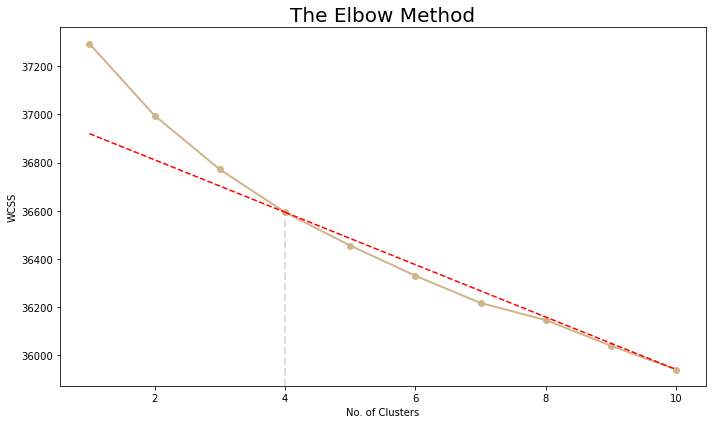

In [709]:
# Elbow method

cmax, wcss  = 11, []
for i in range(1, cmax):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 5, random_state = 0) 
    km.fit(X)
    wcss.append(km.inertia_)

    
# elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, cmax), wcss, 'o-', color='tan', linewidth=2)
plt.axvline(x=4, color='gainsboro', ymin=0, ymax=0.47, linestyle='--', linewidth=2)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')

# slope 1
x_values = [4,10]
y_values = [wcss[3],wcss[9]]
slope = (y_values[1] - y_values[0]) / (x_values[1] - x_values[0])
intercept = y_values[0] - slope * x_values[0]
x_extension = np.linspace(1, x_values[0], num=100)
y_extension = slope * x_extension + intercept
plt.plot(x_extension, y_extension, color='red', linestyle='--')
plt.plot(x_values, y_values, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [710]:
# 1) modello kmeans applicato su tutte le osservazioni, ncluster manuale

ncluster = 4

model = KMeans(n_clusters=ncluster, init='k-means++', max_iter=300, n_init=5, random_state= 77)
model.fit(X)
cluster_ids, cluster_sizes = np.unique(model.labels_, return_counts=True)
print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()

clusters = model.predict(X)
df_topic_kmeans['Cluster'] = clusters

top_terms_df = pd.DataFrame(columns=clustsetter(ncluster))
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = sorted(vectorizer.vocabulary_.keys())

for i in range(ncluster):
    cluster_terms = []
    for ind in order_centroids[i, :10]:
        cluster_terms.append(terms[ind])
    top_terms_df[f'topic {i+1}'] = cluster_terms

y_means = model.fit_predict(X)
silhouette_avg = silhouette_score(X,y_means)
print(top_terms_df)
print(silhouette_avg)

Number of elements asigned to each cluster: [22878  7761  2867  4803]

Top terms per cluster:
   topic 1       topic 2   topic 3   topic 4
0    apple         sound  keyboard   charger
1       wa           ear      ipad    charge
2     work         noise       key     phone
3  product       airpods     magic  charging
4     ipad       quality     apple      cord
5    great         great       use     apple
6      use  cancellation      like    iphone
7     love          good      case      work
8     like           fit      work      case
9      new     headphone       pro   magsafe
0.007817915040139631


In [ ]:
# Analisi esplorativa su cluster

df_topic_kmeans.loc[df_topic_kmeans['Cluster']==0]['Rating'].value_counts()
df_topic_kmeans.loc[df_topic_kmeans['Cluster']==0]['product'].value_counts()

In [711]:
# ricerca recensione più vicina ai centroidi - primo metodo
df_topic_kmeans2 = df_topic_kmeans.copy()

centroids = model.cluster_centers_
distances = model.transform(X)
closest_centroids = np.argmin(distances, axis=1)

df_topic_kmeans2['ClosestCentroid'] = closest_centroids

df_topic_kmeans2 = df_topic_kmeans2.sort_values(by='ClosestCentroid')

closest_reviews = df_topic_kmeans2.groupby('ClosestCentroid').first()

pd.set_option('display.max_colwidth', None)
print(closest_reviews['Text'])
pd.set_option('display.max_colwidth', 70)

ClosestCentroid
0                                                                                                                                                                                                                                                                                    So t know if this is a typo but the advertisement says M2 pro yet specs don't add up m2 pro comes with a 10 core CPU and 16 core GPU yet there's says 10 and 8 also processor in specs says M1...again be aware!
1                                                                                                                                                                                                                                                                                                                                                   sound really good, cancel noise well, and for me battery life very good. only issue is hard to fit in my ear, more an issue with my ears perhaps.
2           

In [712]:
# ricerca recensione più vicina ai centroidi - secondo metodo, non so quale sia giusto, probabilmente i cluster sono equidistanti
centroids = model.cluster_centers_
distances = model.transform(X)
closest_centroids = np.argmin(distances, axis=1)
centroid_reviews = df_topic_kmeans.loc[closest_centroids]

pd.set_option('display.max_colwidth', None)

print(centroid_reviews.loc[centroid_reviews.index==0].head(1)['Text'])
print(centroid_reviews.loc[centroid_reviews.index==1].head(1)['Text'])
print(centroid_reviews.loc[centroid_reviews.index==2].head(1)['Text'])
print(centroid_reviews.loc[centroid_reviews.index==3].head(1)['Text'])

pd.set_option('display.max_colwidth', 70)

0    Review time! Today is my first time using these earphones after the mic on my AirPods went out and needed some corded ones to use with my MacBook Pro. According to others that I have face-timed with while using these earphones they can hear me very well. Also the sound quality of receiving audio is also efficient. I can hear audio clearly out of both earphones which is important to me as I have meetings and spend a lot of time on my computer. I definitely recommend these earphones if you need something reliable just in case there may be some technical difficulties with bluetooth sets.
Name: Text, dtype: object
1    Apple ear pod headphones are the best. I've been using them for the past 10-15 years and the design is the same so I am happy whenever I have to replace them. They fit in my ears perfectly. Times when I tried the cheaper brands, they either hurt my ears or never lasted long. The last pair I had lasted me 6 years. This pair I bought them for my new job to plug into my co

In [713]:
## 2) modello kmeans ridotto a < 3 e togliendo nomi propri prodotti, ncluster manuale

df_negative_topic_kmeans = df_topic_kmeans[['product', 'Rating', 'Text', 'clear_text', 'len']].copy()
df_negative_topic_kmeans = df_negative_topic_kmeans[df_negative_topic_kmeans['Rating'] < 3]
df_negative_topic_kmeans = df_negative_topic_kmeans.reset_index(drop=True)

lista = ['apple','mac', 'lightning', 'thunderbolt', 'magsafe', 'airpods', 'macbook', 'imac', 'keyboard', 'cover', 'iphone', 'watch', 'trackpad', 'mouse', 'pencil', 'beats', 'ipad', 'airtag', 'superdrive']

def remove_prod(text):
    new = []
    for word in text.split():
        if word not in lista:
            new.append(word)
    return ' '.join([w for w in new])

df_negative_topic_kmeans['extra_clear_text'] = df_negative_topic_kmeans['clear_text'].progress_apply(lambda x: remove_prod(x))

X = vectorizer.fit_transform(df_negative_topic_kmeans['extra_clear_text'])
print(f"n_samples: {X.shape[0]}, n_features: {X.shape[1]}")

ncluster = 4 ###

model = KMeans(n_clusters=ncluster, init='k-means++', max_iter=300, n_init=5, random_state= 55)
model.fit(X)
cluster_ids, cluster_sizes = np.unique(model.labels_, return_counts=True)
print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()

clusters = model.predict(X)
df_negative_topic_kmeans['Cluster'] = clusters

top_terms_df = pd.DataFrame(columns=clustsetter(ncluster))
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = sorted(vectorizer.vocabulary_.keys())

for i in range(ncluster):
    cluster_terms = []
    for ind in order_centroids[i, :10]:
        cluster_terms.append(terms[ind])
    top_terms_df[f'topic {i+1}'] = cluster_terms

y_means = model.fit_predict(X)
silhouette_avg = silhouette_score(X,y_means)
print(top_terms_df)
print(silhouette_avg)

  0%|          | 0/6875 [00:00<?, ?it/s]

n_samples: 6875, n_features: 9656
Number of elements asigned to each cluster: [3753  573 1170 1379]

Top terms per cluster:
   topic 1   topic 2   topic 3   topic 4
0     work   stopped   charger        wa
1  product   working    charge    amazon
2      use     month     phone   product
3    month    worked  charging       new
4     time      week      work       box
5     like   product   battery      item
6      ear  charging      case      used
7      buy   charger       usb  received
8   bought    bought      plug    return
9    sound    return       doe      work
0.006031979804965031


In [714]:
# Analisi esplorativa su cluster

df_negative_topic_kmeans.loc[df_negative_topic_kmeans['Cluster']==0]['Rating'].value_counts()
df_negative_topic_kmeans.loc[df_negative_topic_kmeans['Cluster']==0]['product'].value_counts()

Cables      1219
Pods         906
Keyboard     519
Mac          246
Pencil       197
Watch        185
Mouse        158
iPad         141
Case         121
AirTag        29
Trackpad      10
Beats          9
TV             3
Drive          3
Name: product, dtype: int64

In [715]:
df_negative_topic_kmeans2 = df_negative_topic_kmeans.copy()
centroids = model.cluster_centers_
distances = model.transform(X)
closest_centroids = np.argmin(distances, axis=1)
df_negative_topic_kmeans2['ClosestCentroid'] = closest_centroids
df_negative_topic_kmeans2 = df_negative_topic_kmeans2.sort_values(by='ClosestCentroid')
closest_reviews = df_negative_topic_kmeans2.groupby('ClosestCentroid').first()

pd.set_option('display.max_colwidth', None)
print(closest_reviews['Text'])
pd.set_option('display.max_colwidth', 70)

ClosestCentroid
0    strongly prefer softer silicone tips in ears -- better sound isolation, multiple sizes of tips s I can choose a size that doesn't hurt my ears like these apple ones do. maybe my ears are just not a good fit for this design as others seem to do fine with them. cable is slightly shorter than I am used to. unfortunately I waited until after return window closed to try them out. going to go back to the panasonic ergofit which were my standby until this pair. apple is not always better, apparently.
1                                                                                                                                                                                                                                                                                                                                                                                Used it for less than 40 days and the charger has stopped Working. Cannot return  it as well since return windo

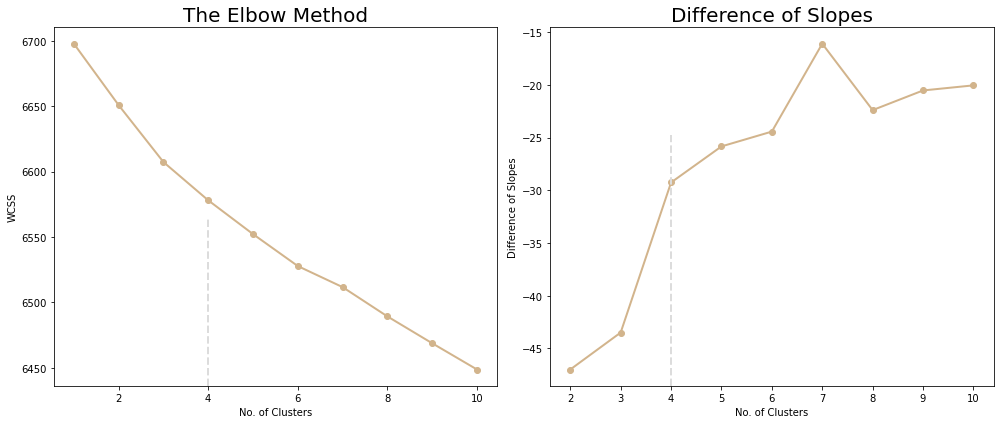

In [716]:
# Metodo del gomito per scelta ncluster più differenza slopes (non utilizzato)

cmax, wcss = 11, []
for i in range(1, cmax):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=5, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)

slopes_diff = np.diff(wcss)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico del metodo del gomito
axs[0].plot(range(1, cmax), wcss, 'o-', color='tan', linewidth=2)
axs[0].axvline(x=4, color='gainsboro', ymin=0, ymax=0.47, linestyle='--', linewidth=2)
axs[0].set_title('The Elbow Method', fontsize=20)
axs[0].set_xlabel('No. of Clusters')
axs[0].set_ylabel('WCSS')

# Grafico della differenza di pendenze
axs[1].plot(range(2, cmax), slopes_diff, 'o-', color='tan', linewidth=2)
axs[1].axvline(x=4, color='gainsboro', ymin=0, ymax=0.70, linestyle='--', linewidth=2)
axs[1].set_title('Difference of Slopes', fontsize=20)
axs[1].set_xlabel('No. of Clusters')
axs[1].set_ylabel('Difference of Slopes')

plt.tight_layout()
plt.show()

## Topic modelling with SVD

In [292]:
from sklearn.decomposition import TruncatedSVD

In [327]:
df_topic_SVD = df_topic[['product','Rating','Text']].copy()

In [328]:
# preproces for scikit tfidf

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preparation2(text:str) -> str:
    # Remove white spaces, punctations and digits
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text)
    # Lowercasing
    text = text.lower()
    # Lemmatizing
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # Remove stopwords
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop])
    return text

df_topic_SVD['clear_text'] = df_topic_SVD['Text'].progress_apply(lambda x: preparation2(x))

  0%|          | 0/63265 [00:00<?, ?it/s]

In [329]:
# negative and not spanish

df_topic_SVD = df_topic_SVD[['product','Rating','Text','clear_text']].copy()
df_topic_SVD = df_topic_SVD[df_topic_SVD['Rating'] < 3]
df_topic_SVD = df_topic_SVD.reset_index(drop=True)

products = {'Cables' : ['USB-C', 'Lightning', 'Thunderbolt', 'MagSafe', 'Adapter', 'Wireless','12W','Cable'],
            'Pods' : ['EarPods' , 'AirPods'], 'Mac' : ['MacBook', 'iMac', 'Mac Mini'], 'Keyboard' :['Keyboard'],
            'Case' : ['Cover', 'Folio','Follo', 'iPhone'], 'Watch' : ['Watch'] , 'Trackpad' : ['Trackpad'], 
            'Mouse' : ['Mouse'],'Pencil' : ['Pencil'], 'Beats' : ['Beats'], 'iPad' : ['iPad'], 
            'AirTag':[ 'AirTag'], 'Drive':['SuperDrive'], 'TV':['TV'], }

lista = ['apple','muy','que','para','buena','bueno','excelente','el','pero','producto',
        'calidad','los','por','buen','todo','como','me','la','lo','se','en','carga','muy','pero']

for prod in products:
    for prodd in products[prod]:
        lista.append(prodd.lower())
        
def remove_prod(text):
    new = []
    for word in text.split():
        if word not in lista:
            new.append(word)
    return ' '.join([w for w in new])

df_topic_SVD['ct_no_prod'] = df_topic_SVD['clear_text'].progress_apply(lambda x: remove_prod(x))

  0%|          | 0/9482 [00:00<?, ?it/s]

In [330]:
vectorizer = TfidfVectorizer(stop_words="english", smooth_idf=True)
tfidf_matrix = vectorizer.fit_transform(df_topic_SVD['clear_text'])

In [331]:
svd_modeling= TruncatedSVD(n_components=4, algorithm='randomized', n_iter=100, random_state=77)
svd_modeling.fit(tfidf_matrix)
components=svd_modeling.components_
vocab = sorted(vectorizer.vocabulary_.keys())

In [332]:
topic_word_list = []
def get_topics(components): 
    for i, comp in enumerate(components):
        terms_comp = zip(vocab,comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        topic=" "
        for t in sorted_terms:
            topic= topic + ' ' + t[0]
            topic_word_list.append(topic)
            print(topic_word_list)
    return topic_word_list

get_topics(components)

['  work']
['  work', '  work apple']
['  work', '  work apple', '  work apple wa']
['  work', '  work apple', '  work apple wa', '  work apple wa charge']
['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working']
['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working', '  work apple wa charge working product']
['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working', '  work apple wa charge working product', '  work apple wa charge working product month']
['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working', '  work apple wa charge working product', '  work apple wa charge working product month', '  working']
['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working', '  work apple wa charge working product', '  work apple wa charge working produ

['  work',
 '  work apple',
 '  work apple wa',
 '  work apple wa charge',
 '  work apple wa charge working',
 '  work apple wa charge working product',
 '  work apple wa charge working product month',
 '  working',
 '  working stopped',
 '  working stopped month',
 '  working stopped month week',
 '  working stopped month week worked',
 '  working stopped month week worked day',
 '  working stopped month week worked day lasted',
 '  work',
 '  work working',
 '  work working stopped',
 '  work working stopped month',
 '  work working stopped month doe',
 '  work working stopped month doe week',
 '  work working stopped month doe week return',
 '  charge',
 '  charge phone',
 '  charge phone charger',
 '  charge phone charger charging',
 '  charge phone charger charging iphone',
 '  charge phone charger charging iphone doe',
 '  charge phone charger charging iphone doe battery']

In [ ]:
# wordcloud

from wordcloud import WordCloud

for i in range(4):
    wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[i])
    plt.imshow(wc)
    plt.title(f"Topic{i+1}")
    plt.axis("off")
    plt.show()

In [337]:
# NMF 

from sklearn.decomposition import NMF
NMF_model = NMF(n_components=4, random_state=77)
W = NMF_model.fit_transform(tfidf_matrix)
H = NMF_model.components_

get_topics(H)

['  work', '  work apple', '  work apple wa', '  work apple wa charge', '  work apple wa charge working', '  work apple wa charge working product', '  work apple wa charge working product month', '  working', '  working stopped', '  working stopped month', '  working stopped month week', '  working stopped month week worked', '  working stopped month week worked day', '  working stopped month week worked day lasted', '  work', '  work working', '  work working stopped', '  work working stopped month', '  work working stopped month doe', '  work working stopped month doe week', '  work working stopped month doe week return', '  charge', '  charge phone', '  charge phone charger', '  charge phone charger charging', '  charge phone charger charging iphone', '  charge phone charger charging iphone doe', '  charge phone charger charging iphone doe battery', '  apple', '  apple wa', '  apple wa product', '  apple wa product ipad', '  apple wa product ipad new', '  apple wa product ipad new a

['  work',
 '  work apple',
 '  work apple wa',
 '  work apple wa charge',
 '  work apple wa charge working',
 '  work apple wa charge working product',
 '  work apple wa charge working product month',
 '  working',
 '  working stopped',
 '  working stopped month',
 '  working stopped month week',
 '  working stopped month week worked',
 '  working stopped month week worked day',
 '  working stopped month week worked day lasted',
 '  work',
 '  work working',
 '  work working stopped',
 '  work working stopped month',
 '  work working stopped month doe',
 '  work working stopped month doe week',
 '  work working stopped month doe week return',
 '  charge',
 '  charge phone',
 '  charge phone charger',
 '  charge phone charger charging',
 '  charge phone charger charging iphone',
 '  charge phone charger charging iphone doe',
 '  charge phone charger charging iphone doe battery',
 '  apple',
 '  apple wa',
 '  apple wa product',
 '  apple wa product ipad',
 '  apple wa product ipad new'